In [98]:
library(Seurat)
library(tidyverse)
library(patchwork)

In [2]:
source('../01_milo/milo.R')

In [4]:
ref_obj = qs::qread('../genebasisr_obob5v5/_targets/objects/exp_all_n1xo')
ref_obj = subset(ref_obj, batch == "Batch 1")
DefaultAssay(ref_obj) = 'SCT'
ref_obj

An object of class Seurat 
57395 features across 7321 samples within 3 assays 
Active assay: SCT (25074 features, 3000 variable features)
 2 other assays present: RNA, integrated
 2 dimensional reductions calculated: pca, umap

In [11]:
xe_obj = qs::qread('xenium_a1_processed')
xe_obj

An object of class Seurat 
499 features across 18986 samples within 5 assays 
Active assay: SCT (99 features, 99 variable features)
 4 other assays present: Xenium, BlankCodeword, ControlCodeword, ControlProbe
 2 dimensional reductions calculated: pca, umap
 2 spatial fields of view present: fov zoom

In [144]:
cell_stats = read_csv('/data/petar/fgf1/resolve//baysor_segmentation//32810-1377-slide3_A1-1_results_baysor_results/baysor_cell_stats.csv')
cell_stats %>% head

Rows: 18986 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): cell
dbl (7): x, y, n_transcripts, density, elongation, area, avg_confidence

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


cell           x        y         n_transcripts density elongation area
1 Cell1_4012_26  4011.529  26.44203 138           0.04986 1.381      2768
2 Cell2_4020_72  4020.296  71.72959 196           0.05998 1.831      3268
3 Cell3_3895_189 3894.667 189.22222 117           0.04684 4.285      2498
4 Cell4_3880_239 3879.782 239.14523 482           0.07543 1.157      6390
5 Cell5_4017_126 4016.688 125.86458 192           0.06028 1.188      3185
6 Cell6_3803_344 3803.318 344.18750 176           0.05479 1.858      3212
  avg_confidence
1 0.9854        
2 0.9927        
3 0.9858        
4 0.9974        
5 0.9919        
6 0.9909

In [145]:
colnames(cell_stats)

[1] "cell"           "x"              "y"              "n_transcripts" 
[5] "density"        "elongation"     "area"           "avg_confidence"

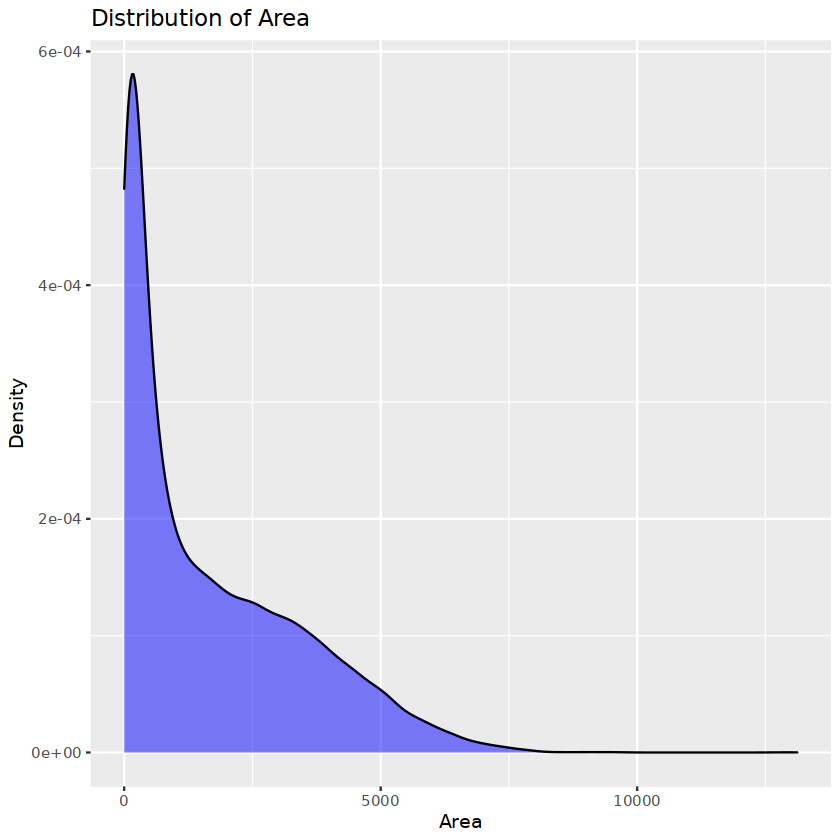

In [13]:
ggplot(cell_stats, aes(x = area)) +
  geom_density(fill = "blue", alpha = 0.5) +
  xlab("Area") +
  ylab("Density") +
  ggtitle("Distribution of Area")

In [14]:
cell_stats %>%
  summarize(cutoff_90 = quantile(area, 0.9),
            cutoff_10 = quantile(area, 0.1))


cutoff_90 cutoff_10
1 4312      51.5

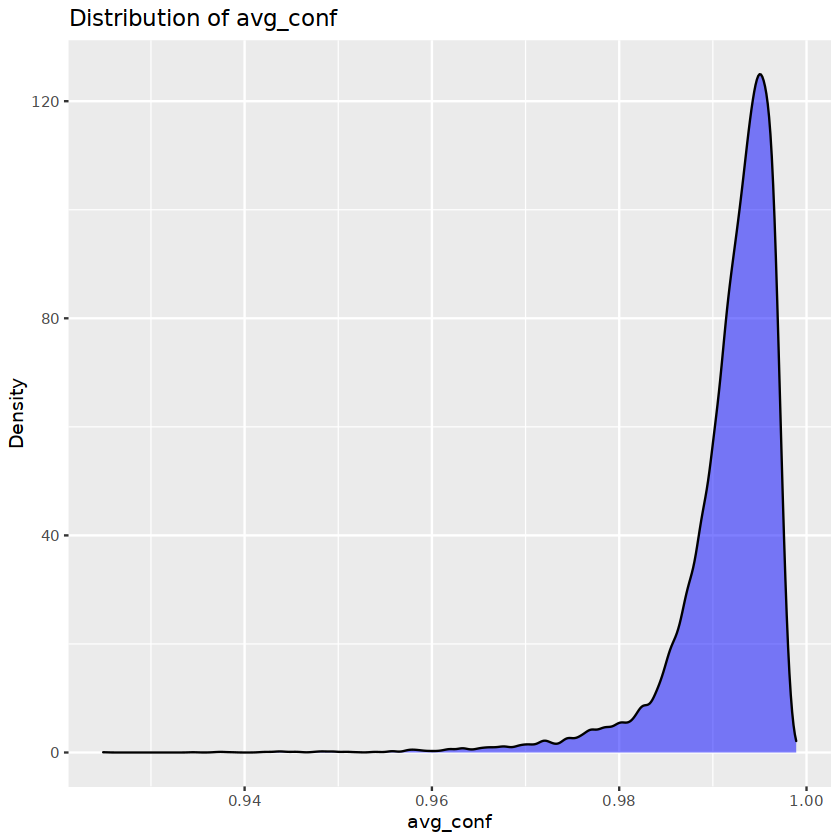

In [15]:
ggplot(cell_stats, aes(x = avg_confidence)) +
  geom_density(fill = "blue", alpha = 0.5) +
  xlab("avg_conf") +
  ylab("Density") +
  ggtitle("Distribution of avg_conf")

In [62]:
keep_cells = cell_stats %>%
filter(area < 4300) %>%
filter(area > 52) %>%
filter(avg_confidence >= 0.99) %>%
pull(cell)

length(keep_cells)

[1] 10717

In [18]:
xe_obj = subset(xe_obj, cells = keep_cells) %>% 
    Seurat::SCTransform(assay='Xenium',
                        method="glmGamPoi",
                        verbose=TRUE)
xe_obj

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 99 by 10717

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 99 genes, 5000 cells



  |======================================================================| 100%


Found 1 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 99 genes



  |======================================================================| 100%


Computing corrected count matrix for 99 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 7.177133 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..SCTransform.Xenium; see ?make.names for more details on syntax validity”


An object of class Seurat 
499 features across 10717 samples within 5 assays 
Active assay: SCT (99 features, 99 variable features)
 4 other assays present: Xenium, BlankCodeword, ControlCodeword, ControlProbe
 2 dimensional reductions calculated: pca, umap
 2 spatial fields of view present: fov zoom

In [108]:
xe_obj = xe_obj %>% ScaleData(assay = 'Xenium')
xe_obj

Centering and scaling data matrix



An object of class Seurat 
552 features across 10717 samples within 6 assays 
Active assay: SCT (99 features, 99 variable features)
 5 other assays present: Xenium, BlankCodeword, ControlCodeword, ControlProbe, prediction.score.labels
 4 dimensional reductions calculated: pca, umap, ref.pca, ref.umap
 2 spatial fields of view present: fov zoom

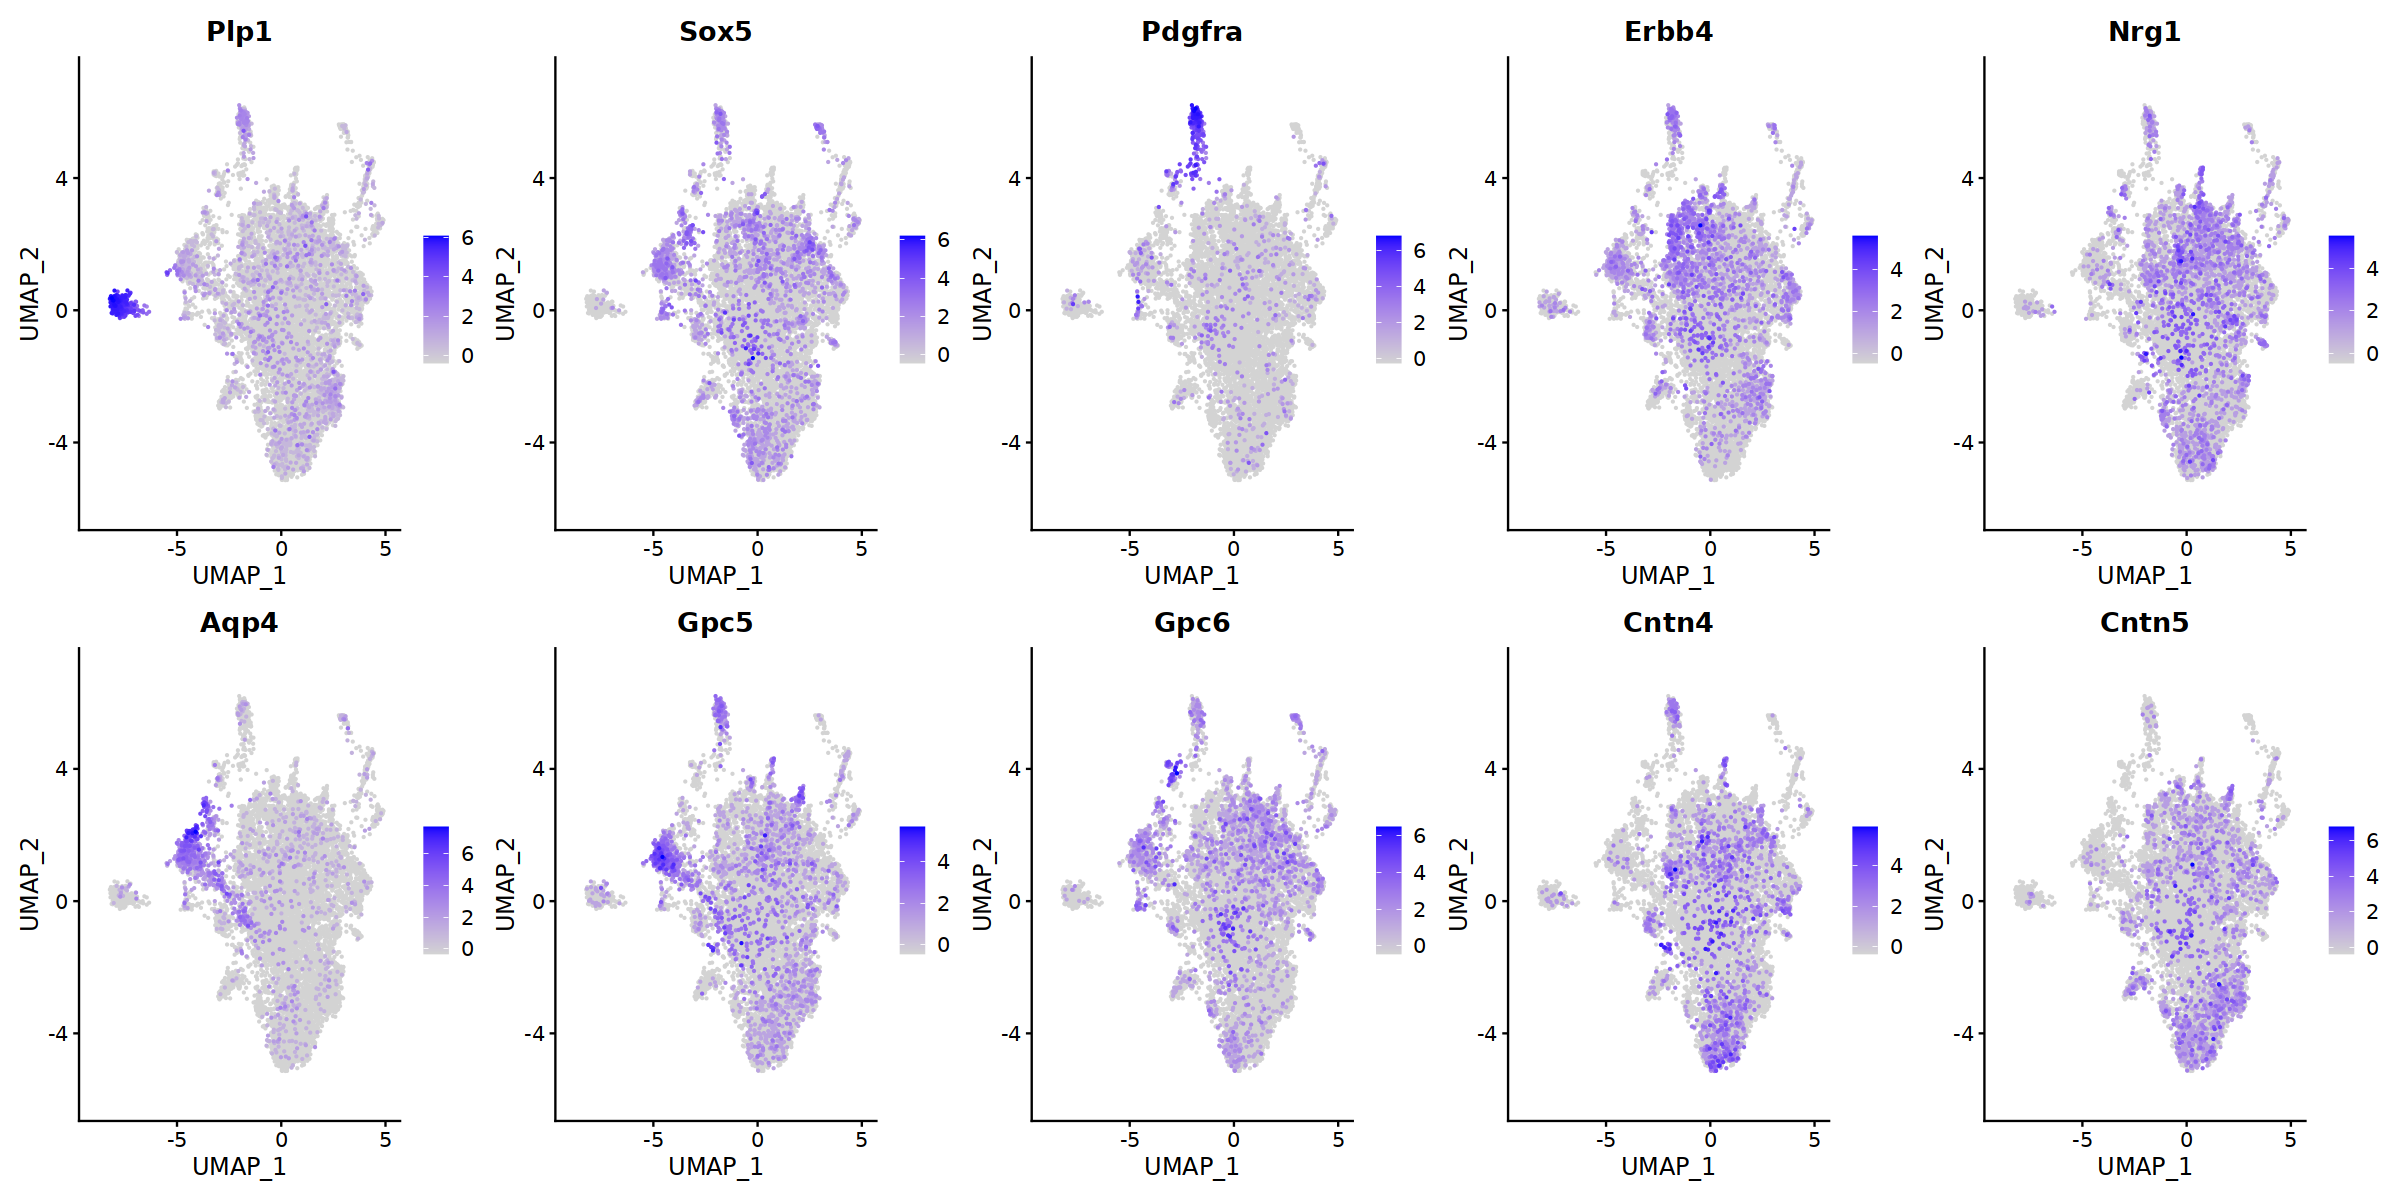

In [113]:
# FeaturePlot(xe_obj, top_neuron_markers, reduction = "umap", ncol = 5, order=TRUE)
options(repr.plot.width=20, repr.plot.height=10)

FeaturePlot(xe_obj,
            c("Plp1", "Sox5", "Pdgfra", "Erbb4", "Nrg1", "Aqp4", "Gpc5", "Gpc6", "Cntn4", "Cntn5"),
            reduction = "umap", slot='scale.data',
            ncol=5, 
            order=TRUE)

In [60]:
xenium_genes = xe_obj@assays$Xenium@meta.features %>% rownames
ref_genes = ref_obj@assays$RNA@meta.features %>% rownames
xenium_genes = xenium_genes %>% intersect(ref_genes)
xenium_genes = xenium_genes %>% tibble %>% filter(. != 'Lmx1a') %>% pull

length(xenium_genes)
xenium_genes

[1] 98

[1] "Sorcs1"   "Lingo2"   "Cntn4"    "Tenm2"    "Sox5"     "Ptprd"   
 [7] "Robo1"    "Plcl1"    "Oxr1"     "Plxdc2"   "Plp1"     "Kirrel3" 
[13] "Mgat4c"   "Tenm3"    "Slit2"    "Nrg3"     "Hdac9"    "Col25a1" 
[19] "Ncam2"    "Rbfox1"   "Fgf13"    "Pde10a"   "Deptor"   "Alcam"   
[25] "Gria1"    "Grid2"    "Grm7"     "Agrp"     "Naaladl2" "Ntm"     
[31] "Gpc5"     "Hs3st4"   "Lef1"     "Erbb4"    "Kctd16"   "Zfhx3"   
[37] "Gtdc1"    "Pdgfra"   "Nrg1"     "Macrod2"  "Gpc6"     "Pcdh11x" 
[43] "Kcnip4"   "Brinp3"   "Cadm2"    "Pde4b"    "Fhit"     "Rgs6"    
[49] "Prkg1"    "Dlg2"     "Ptprk"    "Luzp2"    "Ptprt"    "Nxph1"   
[55] "Kcnq3"    "Lrmda"    "Dcc"      "Cntn5"    "Adarb2"   "Gabrg3"  
[61] "Rmst"     "Lrp1b"    "Trpm3"    "P3h2"     "Prr16"    "Prkca"   
[67] "Nrxn3"    "Aqp4"     "Ctnna2"   "Inpp4b"   "Sgcz"     "Fat3"    
[73] "Plcb1"    "Cacna2d3" "Bmp4"     "Tox"      "Car10"    "Nkain2"  
[79] "Galntl6"  "Slc7a11"  "Pcdh9"    "Slc1a2"   "Pdzrn3"   "Rax"     
[85] "Pomc"     "Zfp804b"  "Wwox"     "Pcdh7"    "Grm8"     "Rtl4"    
[91] "Il1rapl2" "Sgcd"     "Egfem1"   "Arhgap6"  "Immp2l"   "Cfap299" 
[97] "Htr3b"    "Csmd1"

In [119]:
xe_obj = RunUMAP(xe_obj, assay='Xenium', slot='counts', features = xenium_genes)

13:37:10 UMAP embedding parameters a = 0.9922 b = 1.112

13:37:10 Read 10717 rows and found 98 numeric columns

13:37:10 Using Annoy for neighbor search, n_neighbors = 30

13:37:10 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:37:13 Writing NN index file to temp file /scratch/nmq407/R_tmp//RtmpLk0hNb/filee524ba95bb

13:37:13 Searching Annoy index using 1 thread, search_k = 3000

13:37:19 Annoy recall = 100%

13:37:20 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

13:37:23 Initializing from normalized Laplacian + noise (using irlba)

13:37:23 Commencing optimization for 200 epochs, with 525032 positive edges

13:37:39 Optimization finished



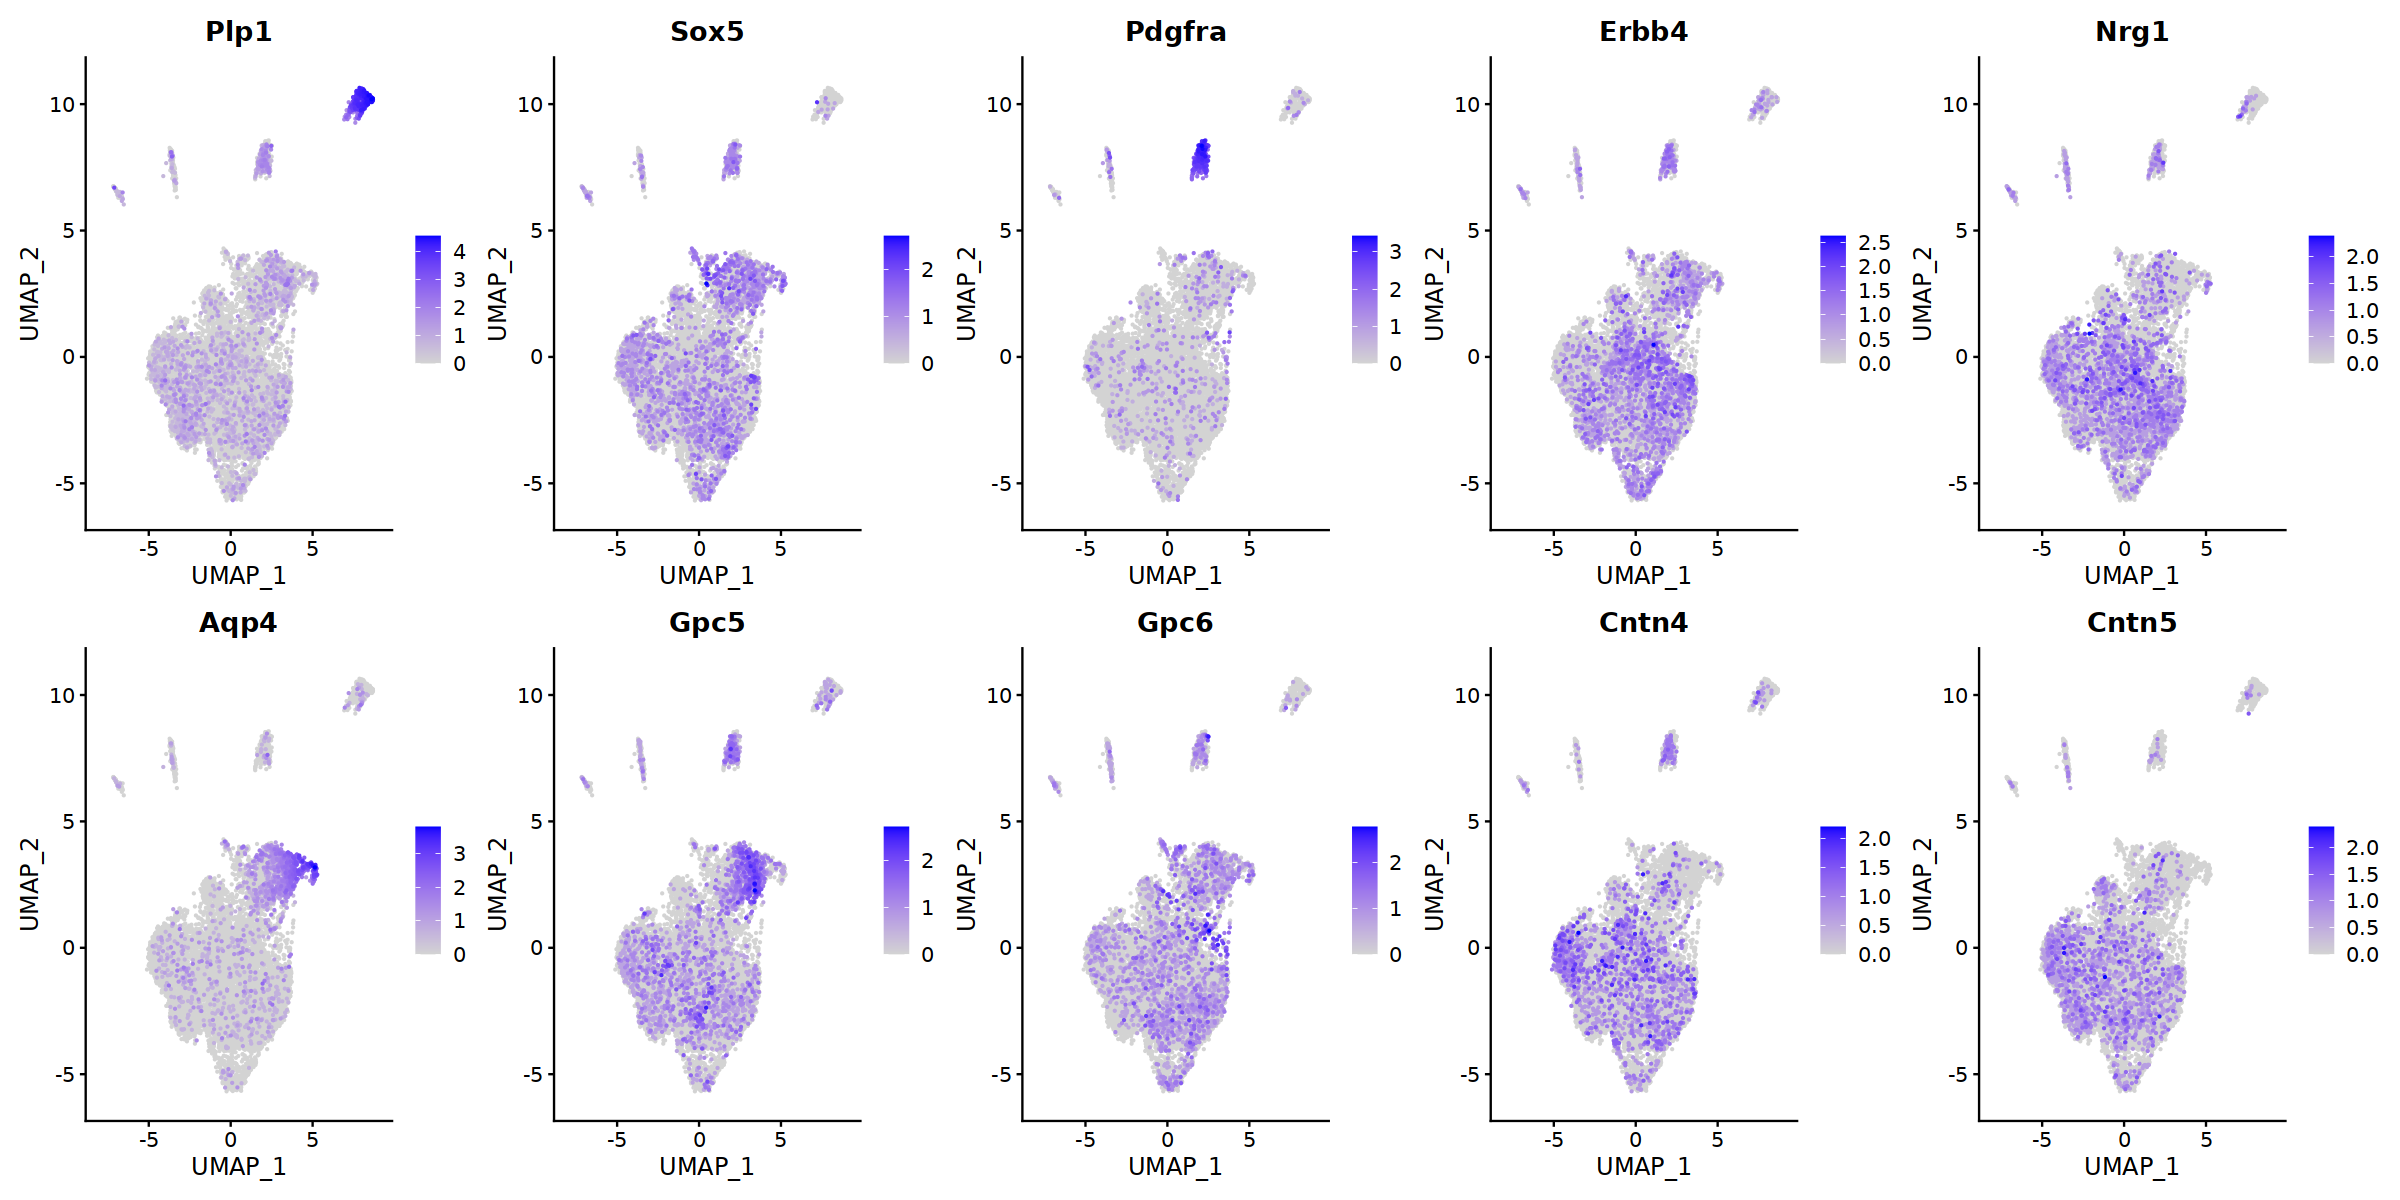

In [120]:
# FeaturePlot(xe_obj, top_neuron_markers, reduction = "umap", ncol = 5, order=TRUE)
options(repr.plot.width=20, repr.plot.height=10)

FeaturePlot(xe_obj,
            c("Plp1", "Sox5", "Pdgfra", "Erbb4", "Nrg1", "Aqp4", "Gpc5", "Gpc6", "Cntn4", "Cntn5"),
            reduction = "umap",
            ncol=5, 
            order=TRUE)

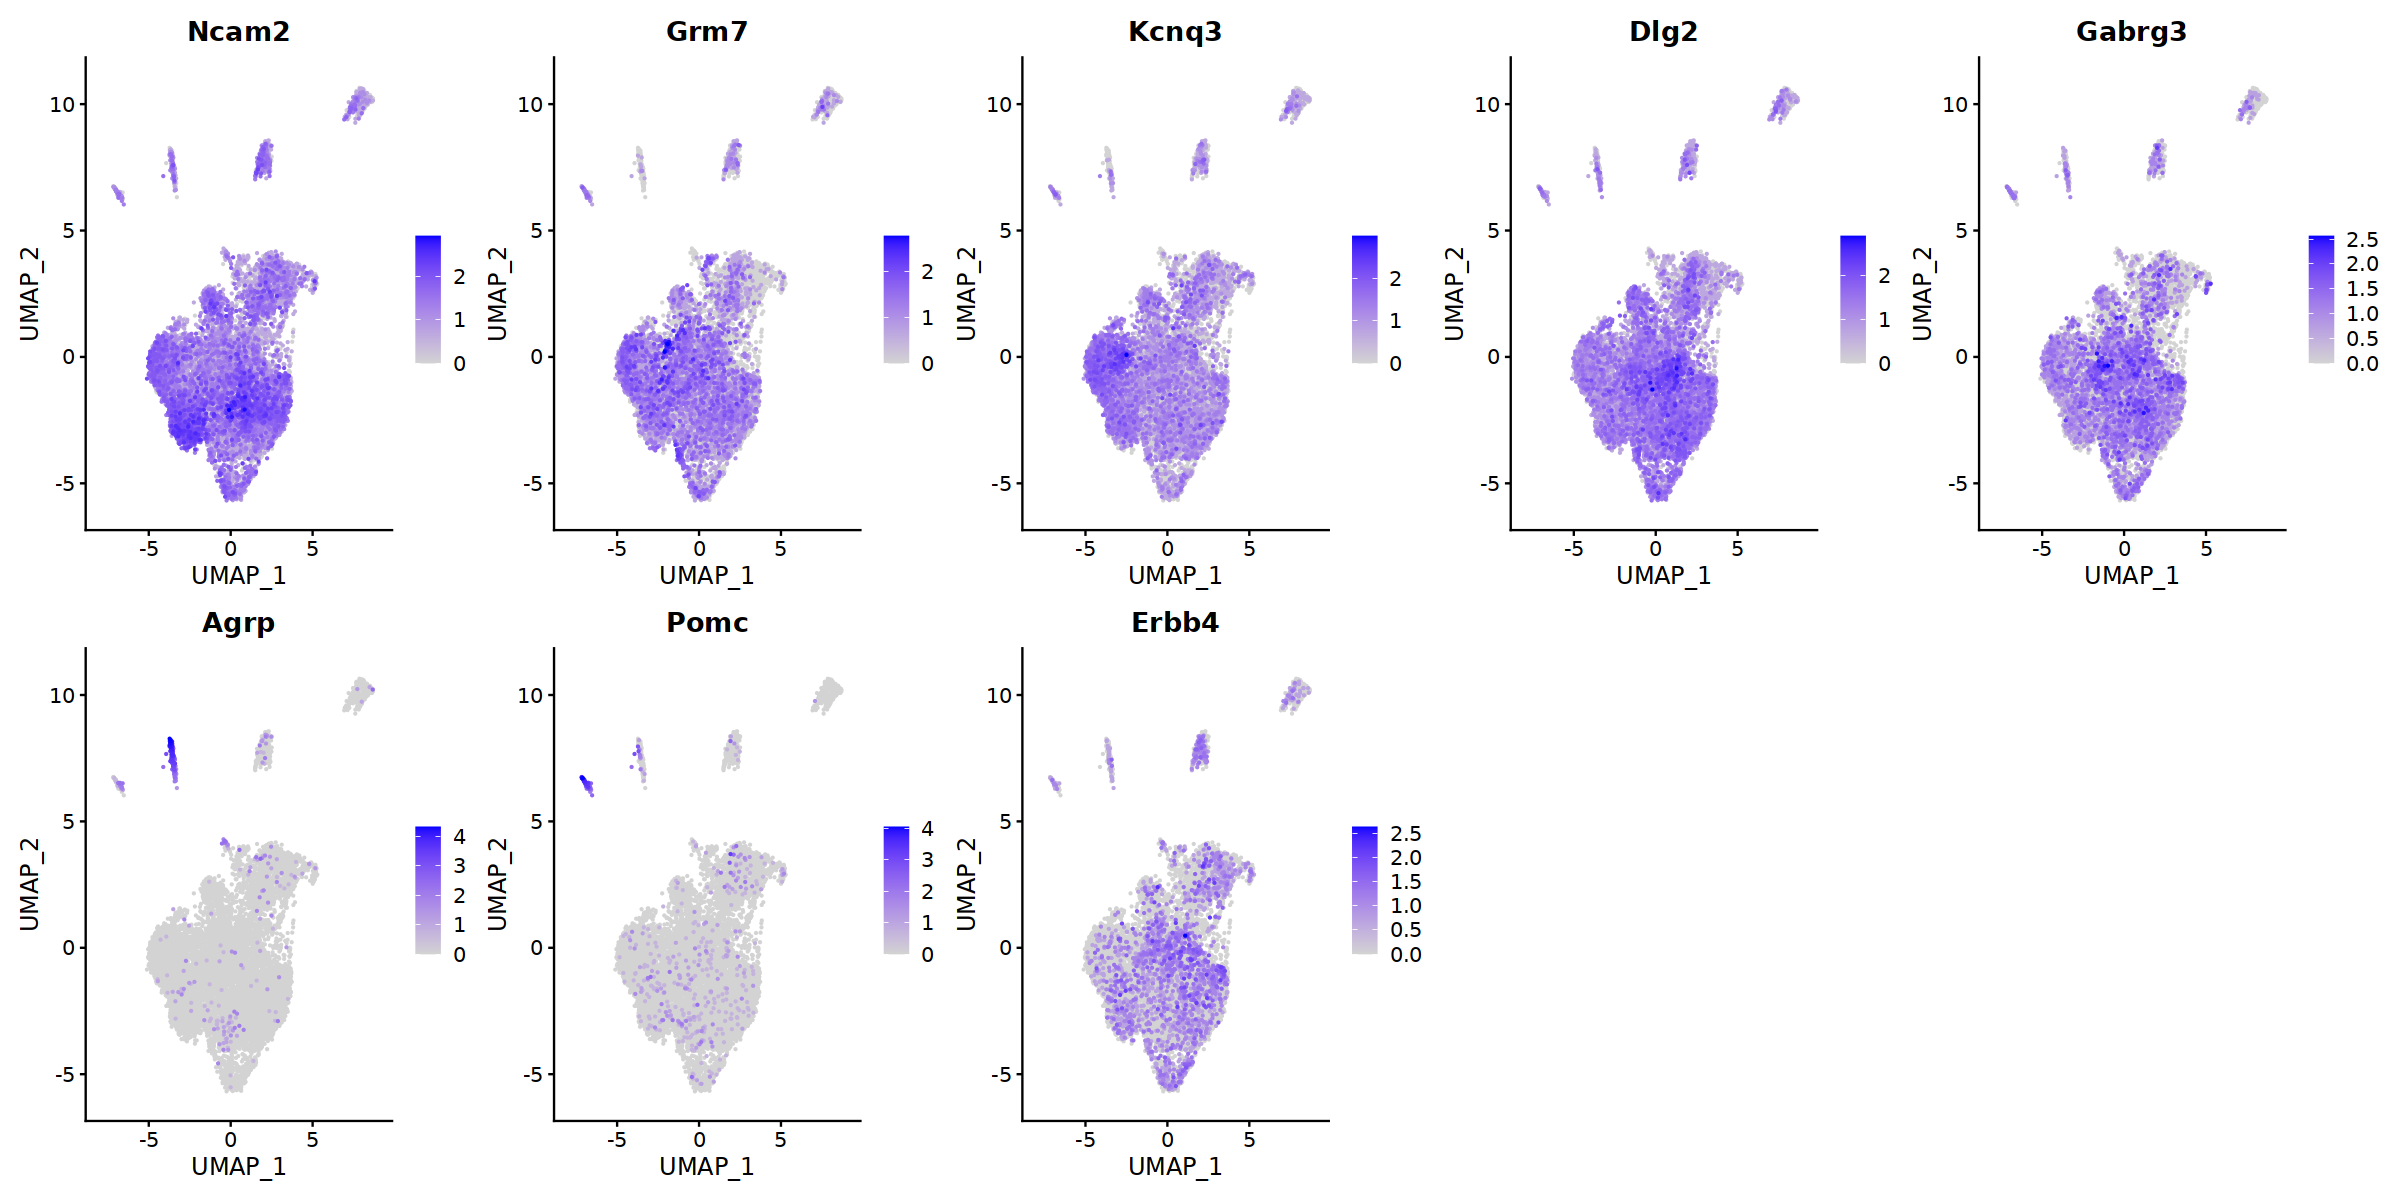

In [121]:
marker_genes <- c("Ncam2", "Grm7", "Kcnq3", "Dlg2", "Gabrg3", "Agrp", "Pomc", "Erbb4")


options(repr.plot.width=20, repr.plot.height=10)

FeaturePlot(xe_obj,
            marker_genes,
            reduction = "umap",
            ncol=5, 
            order=TRUE)

In [123]:
ref_obj = RunUMAP(ref_obj, assay='SCT', slot='counts', features = xenium_genes, return.model = TRUE)

UMAP will return its model

13:38:54 UMAP embedding parameters a = 0.9922 b = 1.112

13:38:54 Read 7321 rows and found 98 numeric columns

13:38:54 Using Annoy for neighbor search, n_neighbors = 30

13:38:54 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:38:56 Writing NN index file to temp file /scratch/nmq407/R_tmp//RtmpLk0hNb/filee5242709d365

13:38:56 Searching Annoy index using 1 thread, search_k = 3000

13:38:59 Annoy recall = 100%

13:39:00 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

13:39:02 Initializing from normalized Laplacian + noise (using irlba)

13:39:03 Commencing optimization for 500 epochs, with 312226 positive edges

13:39:27 Optimization finished



In [124]:
ref_obj

An object of class Seurat 
57395 features across 7321 samples within 3 assays 
Active assay: SCT (25074 features, 3000 variable features)
 2 other assays present: RNA, integrated
 2 dimensional reductions calculated: pca, umap

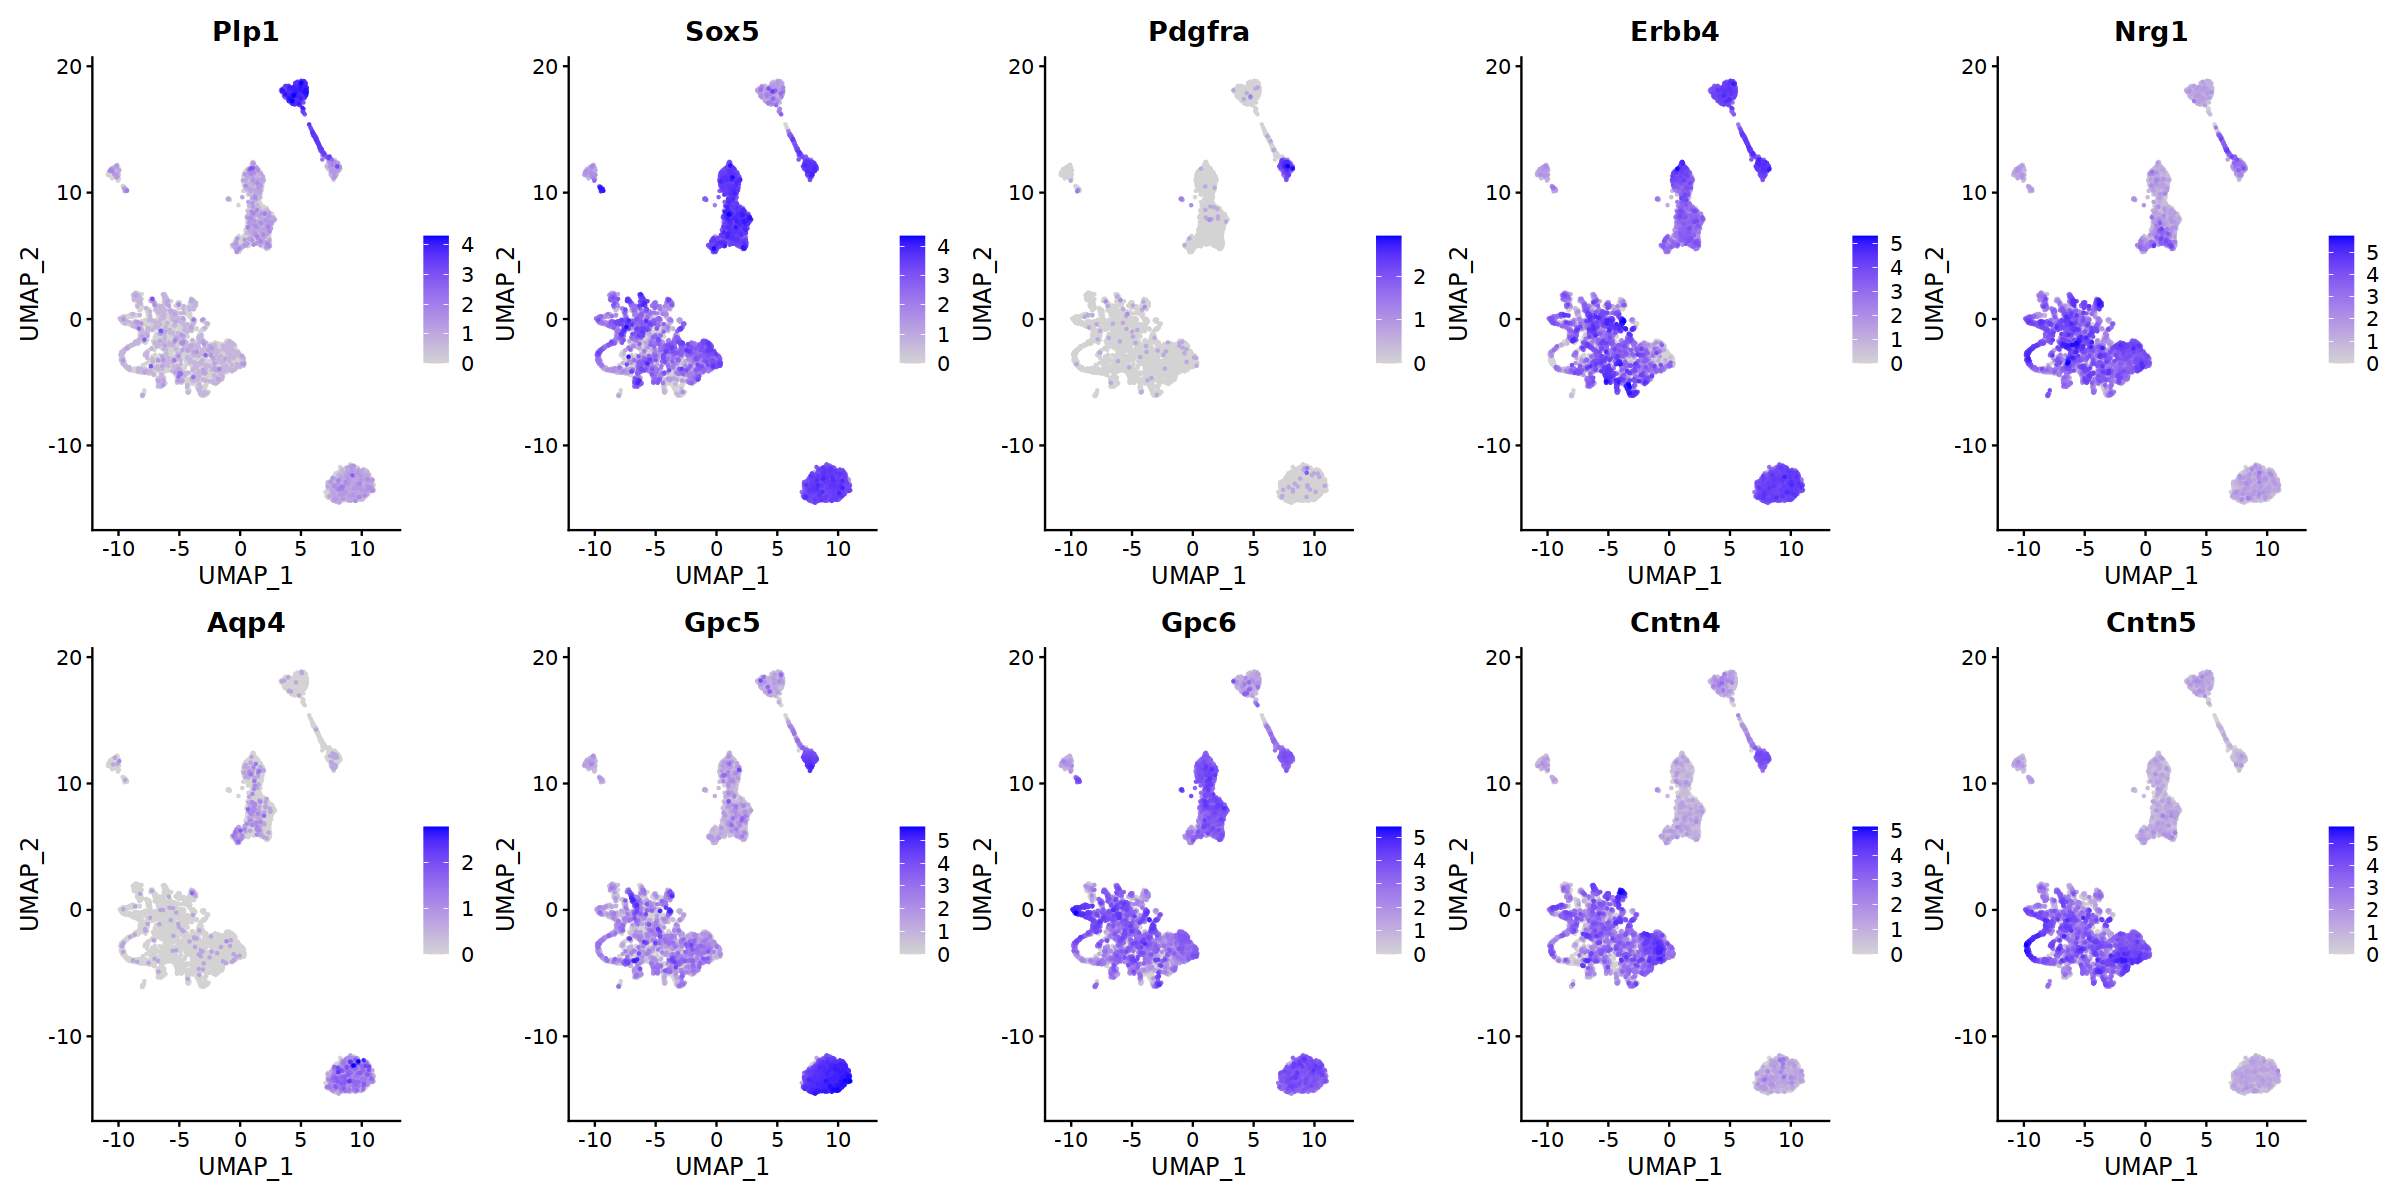

In [125]:
# FeaturePlot(xe_obj, top_neuron_markers, reduction = "umap", ncol = 5, order=TRUE)
options(repr.plot.width=20, repr.plot.height=10)

FeaturePlot(ref_obj,
            c("Plp1", "Sox5", "Pdgfra", "Erbb4", "Nrg1", "Aqp4", "Gpc5", "Gpc6", "Cntn4", "Cntn5"),
            reduction = "umap",
            ncol=5, 
            order=TRUE)

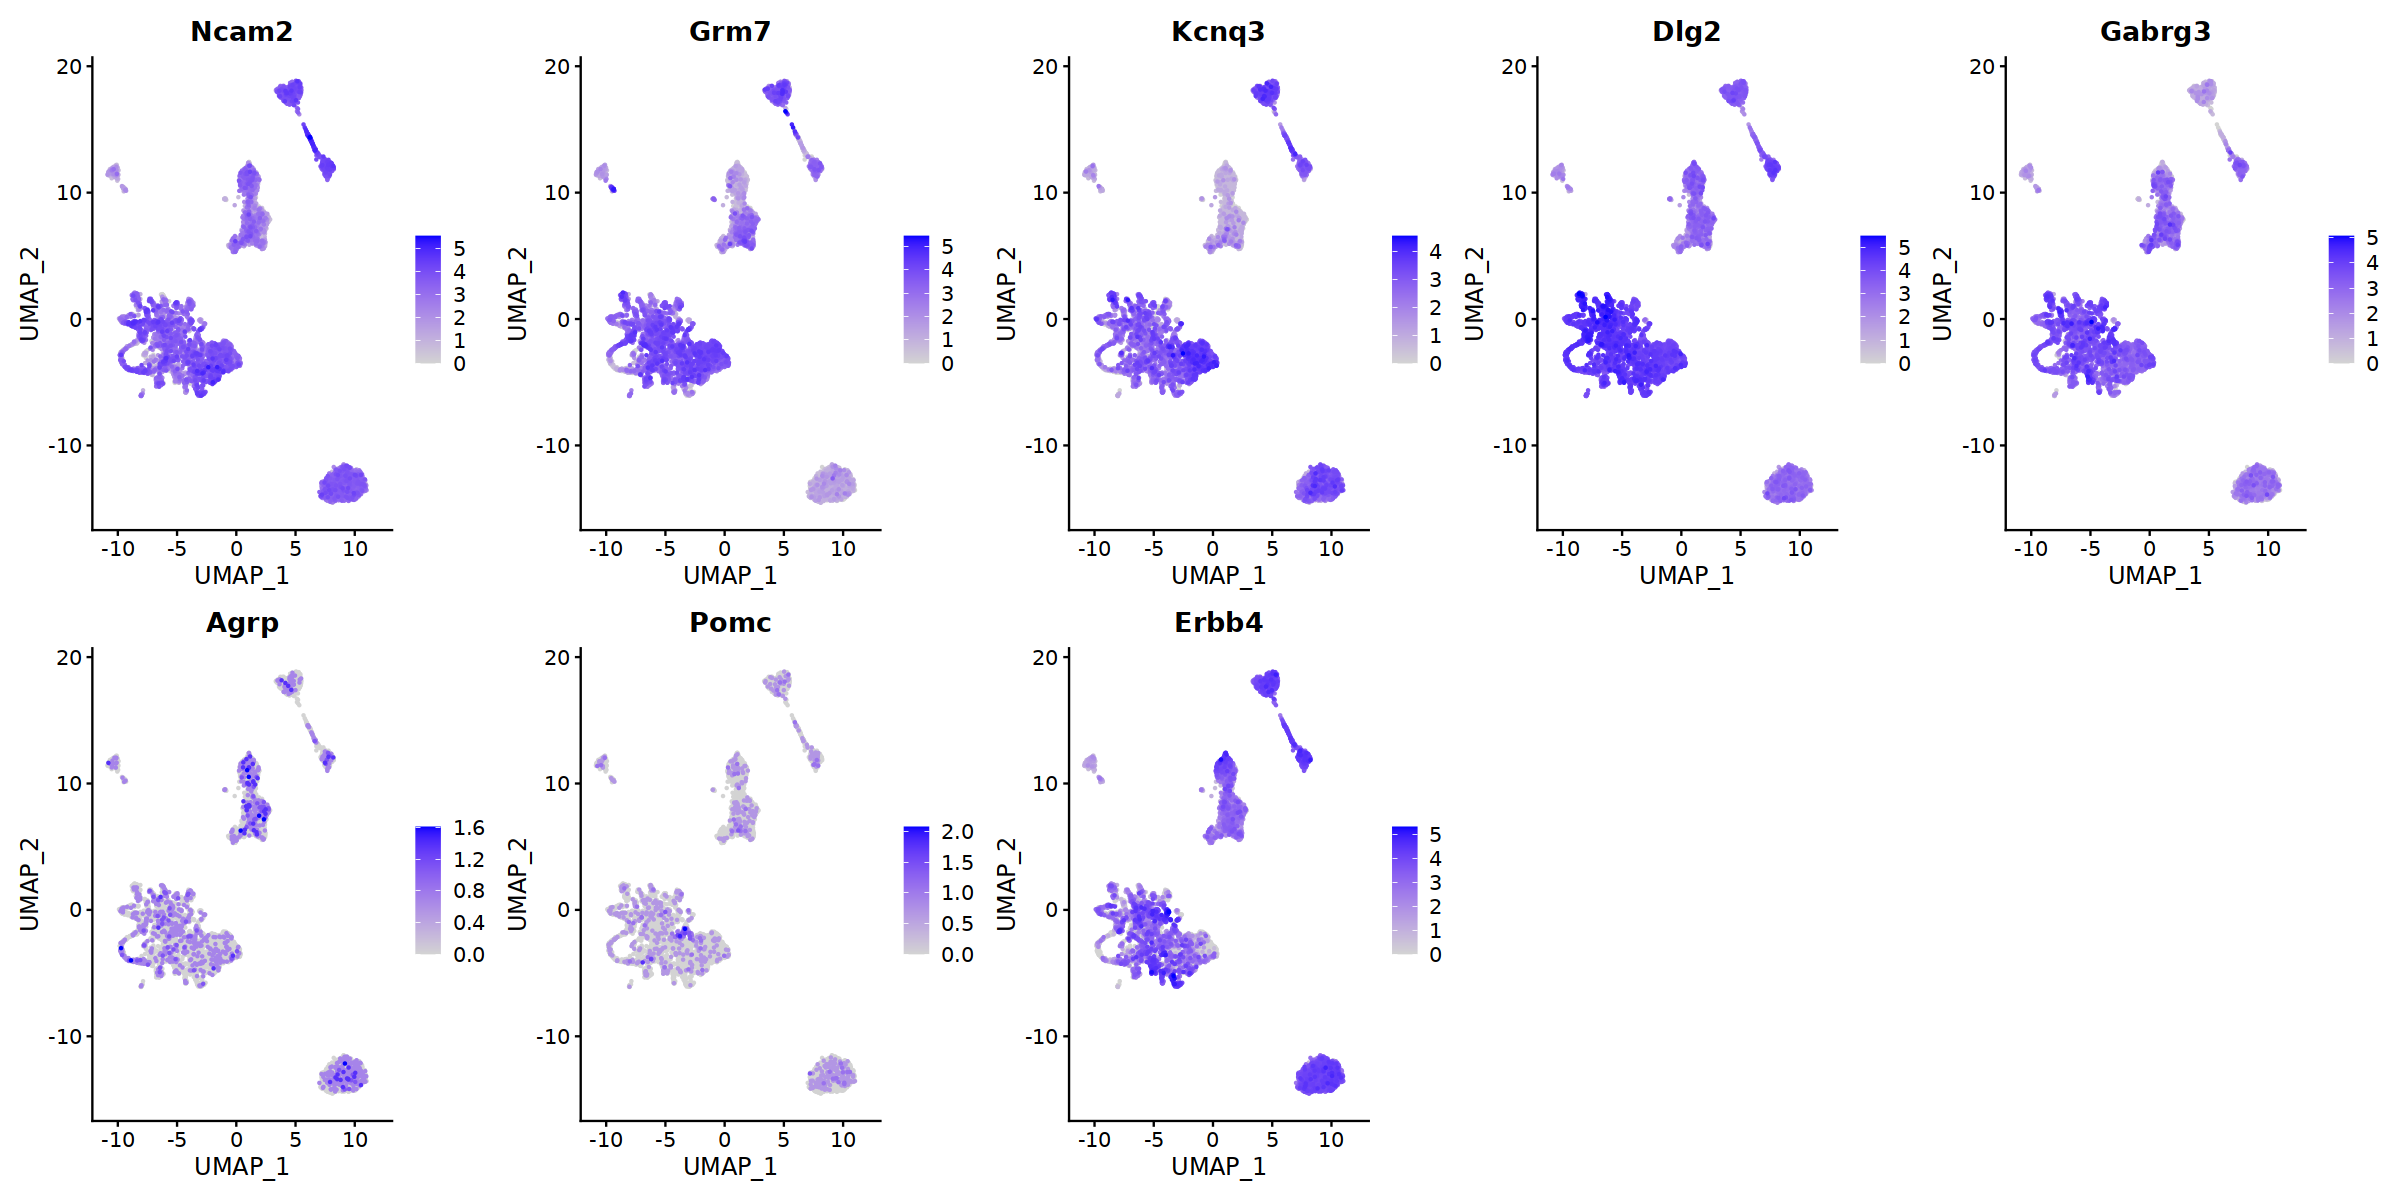

In [126]:
marker_genes <- c("Ncam2", "Grm7", "Kcnq3", "Dlg2", "Gabrg3", "Agrp", "Pomc", "Erbb4")


options(repr.plot.width=20, repr.plot.height=10)

FeaturePlot(ref_obj,
            marker_genes,
            reduction = "umap",
            ncol=5, 
            order=TRUE)

In [65]:
obj_list = list(ref_obj = ref_obj, xe_obj = xe_obj)

In [127]:
# anchors = FindIntegrationAnchors(obj_list, assay=c('SCT', 'SCT'), anchor.features=xenium_genes)
anchors <- FindTransferAnchors(reference = ref_obj, query = xe_obj, features = xenium_genes,  
                               normalization.method = 'SCT',
                               query.assay = 'Xenium',
                               reference.assay = 'SCT',
                               reference.reduction = "pca")

Normalizing query using reference SCT model

Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 2705 anchors



In [128]:
anchors

An AnchorSet object containing 2705 anchors between the reference and query Seurat objects. 
 This can be used as input to TransferData.

In [129]:
xe_obj <- MapQuery(anchorset = anchors, reference = ref_obj, query = xe_obj,
    refdata = list(labels = "labels"), reference.reduction = "pca", reduction.model = "umap")

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”

Integrating dataset 2 with reference dataset

Finding integration vectors

Integrating data

Computing nearest neighbors

Running UMAP projection

13:55:17 Read 10717 rows

13:55:17 Processing block 1 of 1

13:55:17 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

13:55:18 Initializing by weighted average of neighbor coordinates using 1 thread

13:55:18 Commencing optimization for 167 epochs, with 321510 positive edges

13:55:29 Finished



In [130]:
xe_obj

An object of class Seurat 
552 features across 10717 samples within 6 assays 
Active assay: SCT (99 features, 99 variable features)
 5 other assays present: Xenium, BlankCodeword, ControlCodeword, ControlProbe, prediction.score.labels
 4 dimensional reductions calculated: pca, umap, ref.pca, ref.umap
 2 spatial fields of view present: fov zoom

In [131]:
options(repr.plot.width=20, repr.plot.height=20)
p1 = DimPlot(xe_obj, reduction = "umap", group.by = "predicted.labels", label = TRUE, repel = TRUE)+
  theme(legend.position = "none")



In [132]:
options(repr.plot.width=20, repr.plot.height=20)
p2 = DimPlot(xe_obj, reduction = "ref.umap", group.by = "predicted.labels", label = TRUE, repel = TRUE)+
  theme(legend.position = "none")



In [133]:
options(repr.plot.width=20, repr.plot.height=20)
p3 = DimPlot(ref_obj, reduction = "umap", group.by = "labels", label = TRUE, repel = TRUE)+
  theme(legend.position = "none")


Warning message:
“ggrepel: 25 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


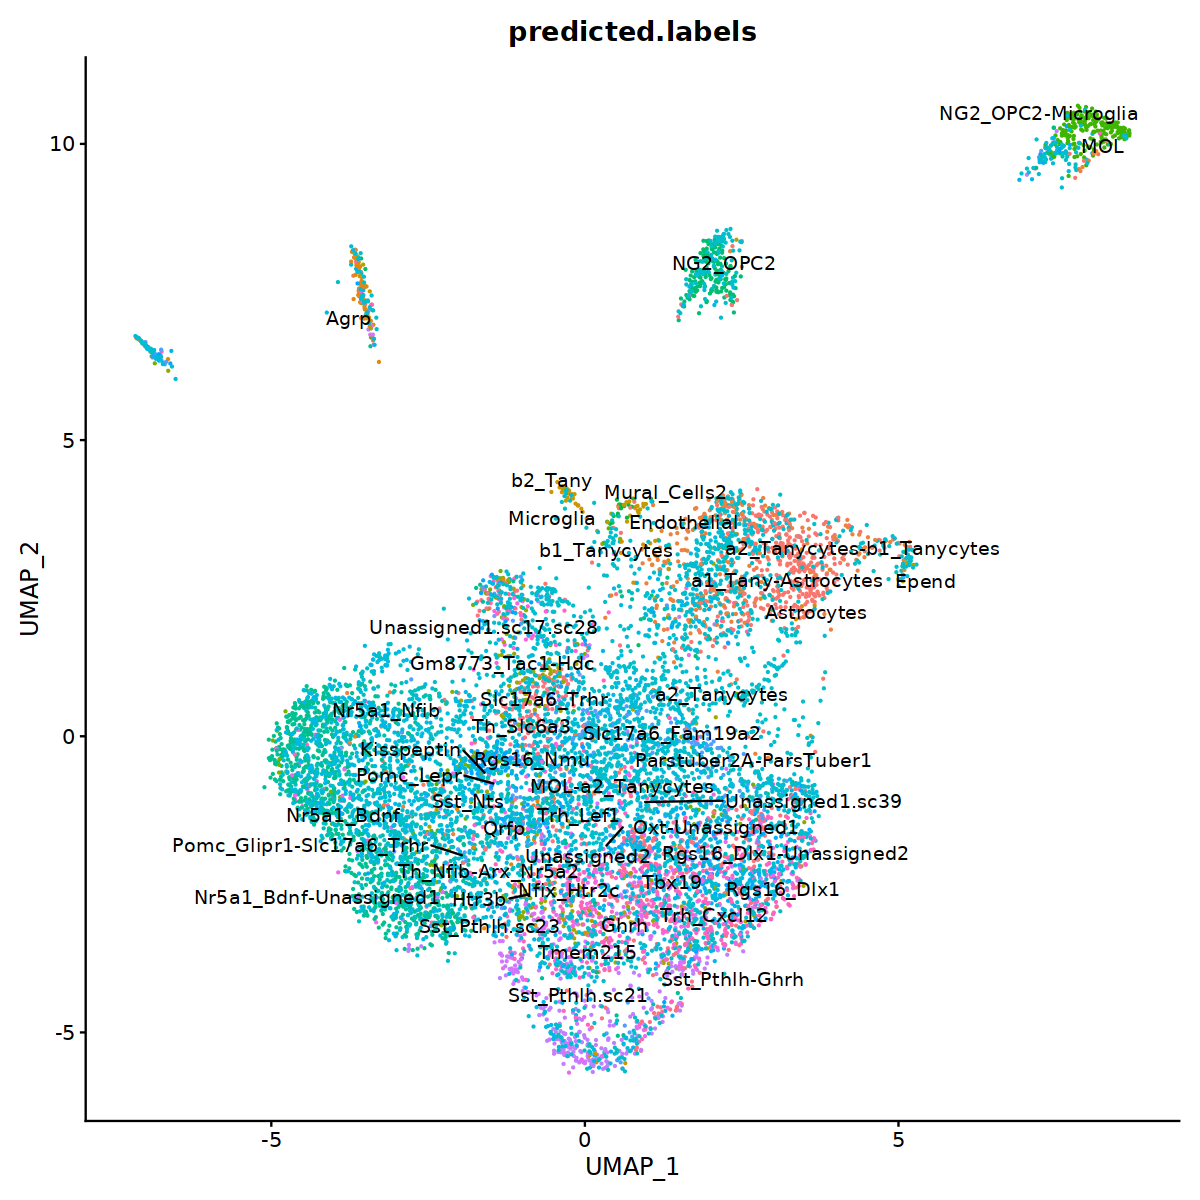

In [138]:
options(repr.plot.width=10, repr.plot.height=10)
p1

Warning message:
“ggrepel: 37 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 30 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


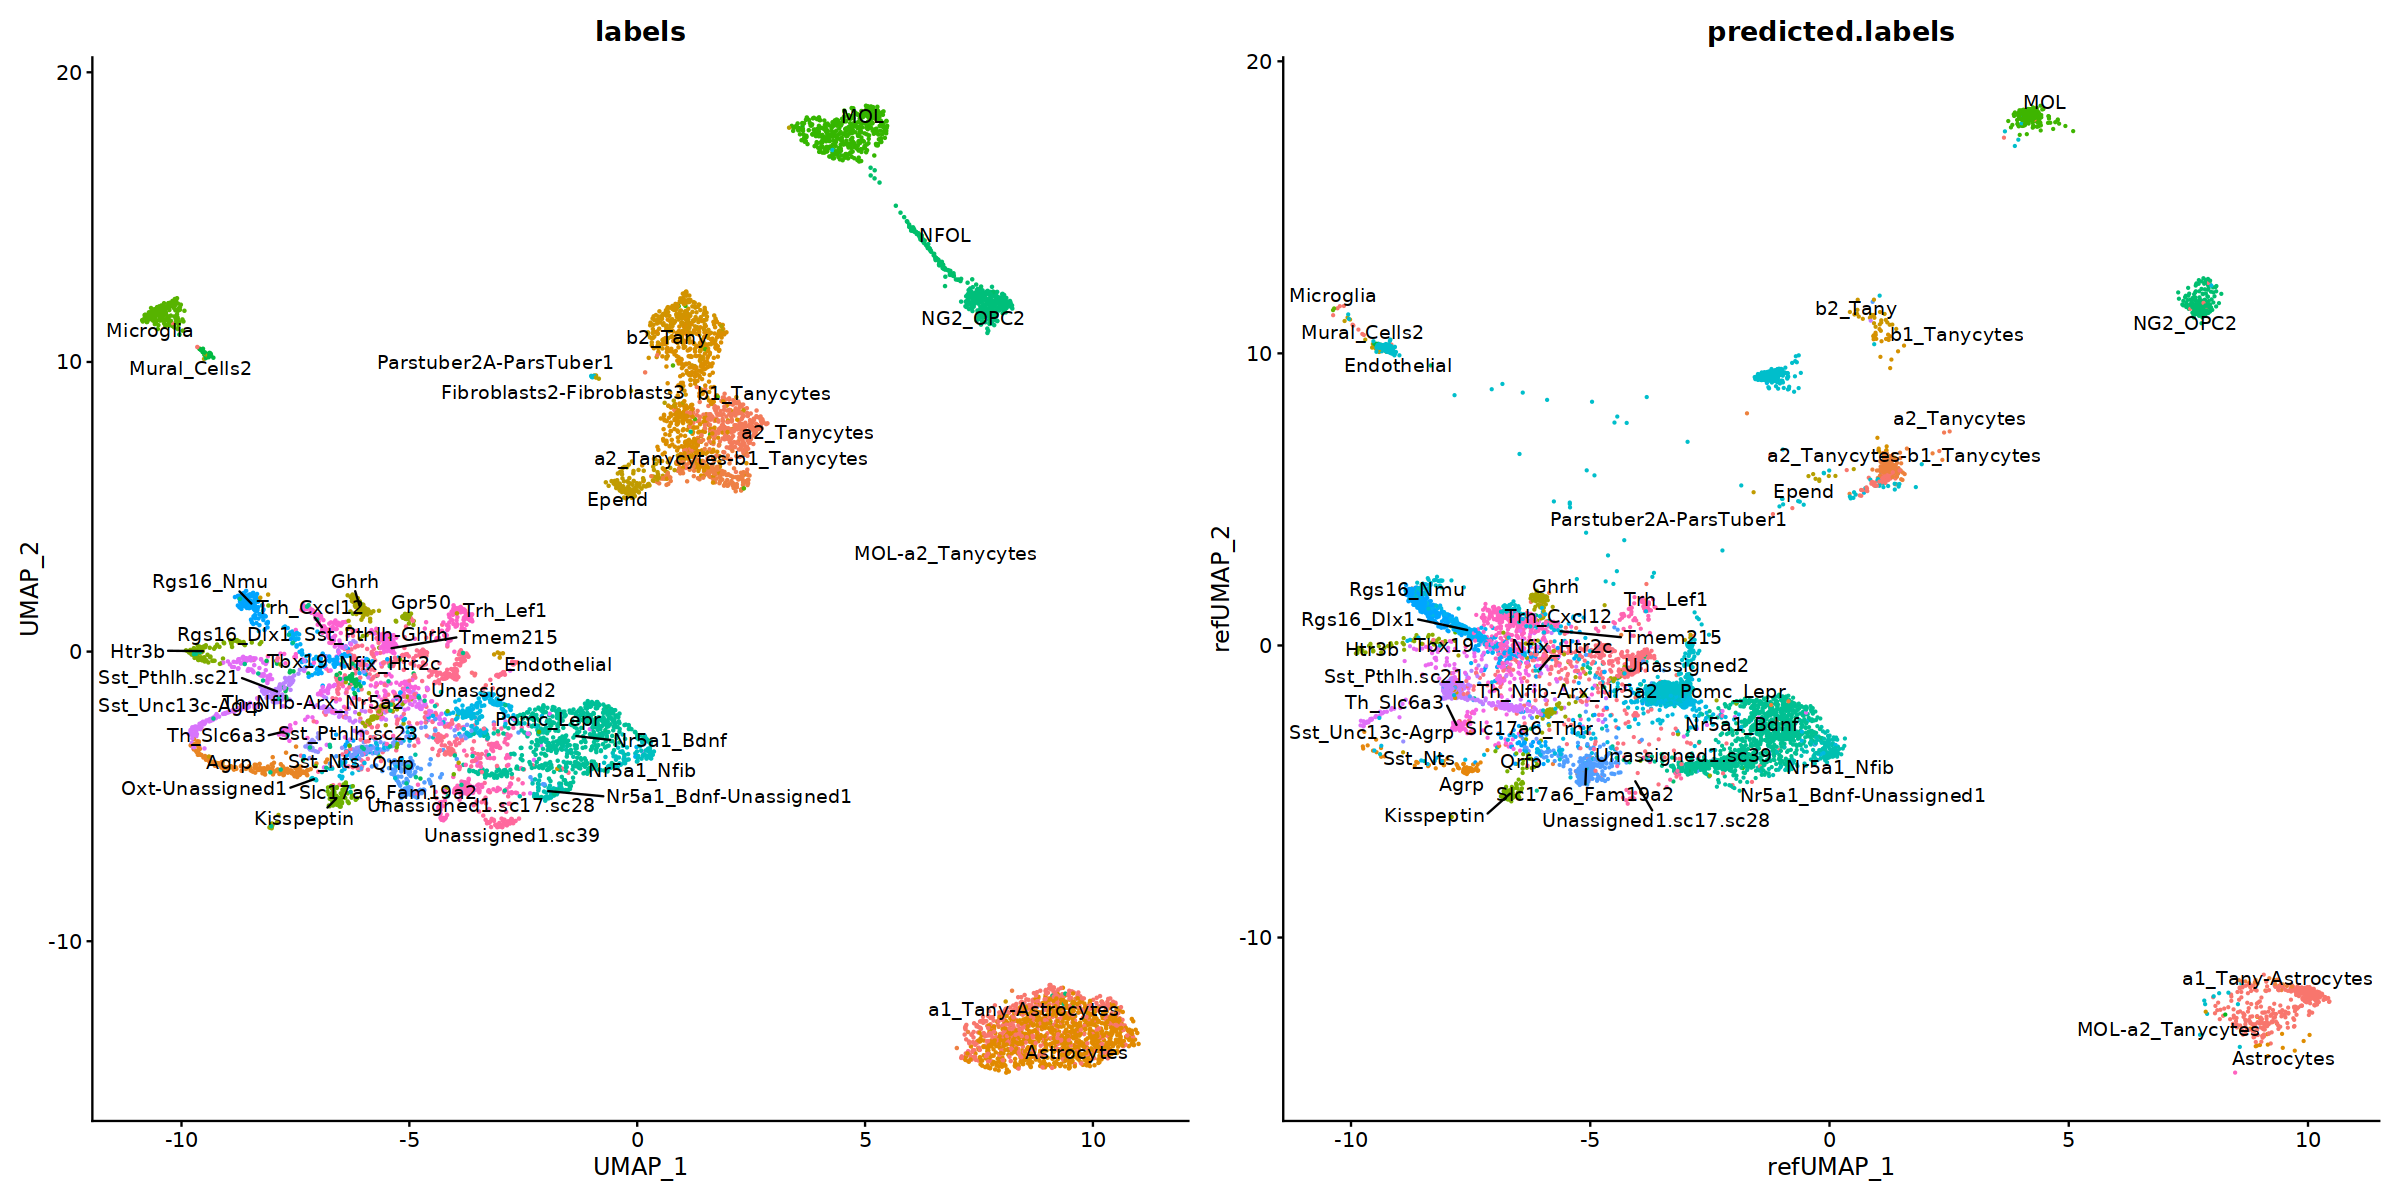

In [134]:
options(repr.plot.width=20, repr.plot.height=10)
p3 + p2

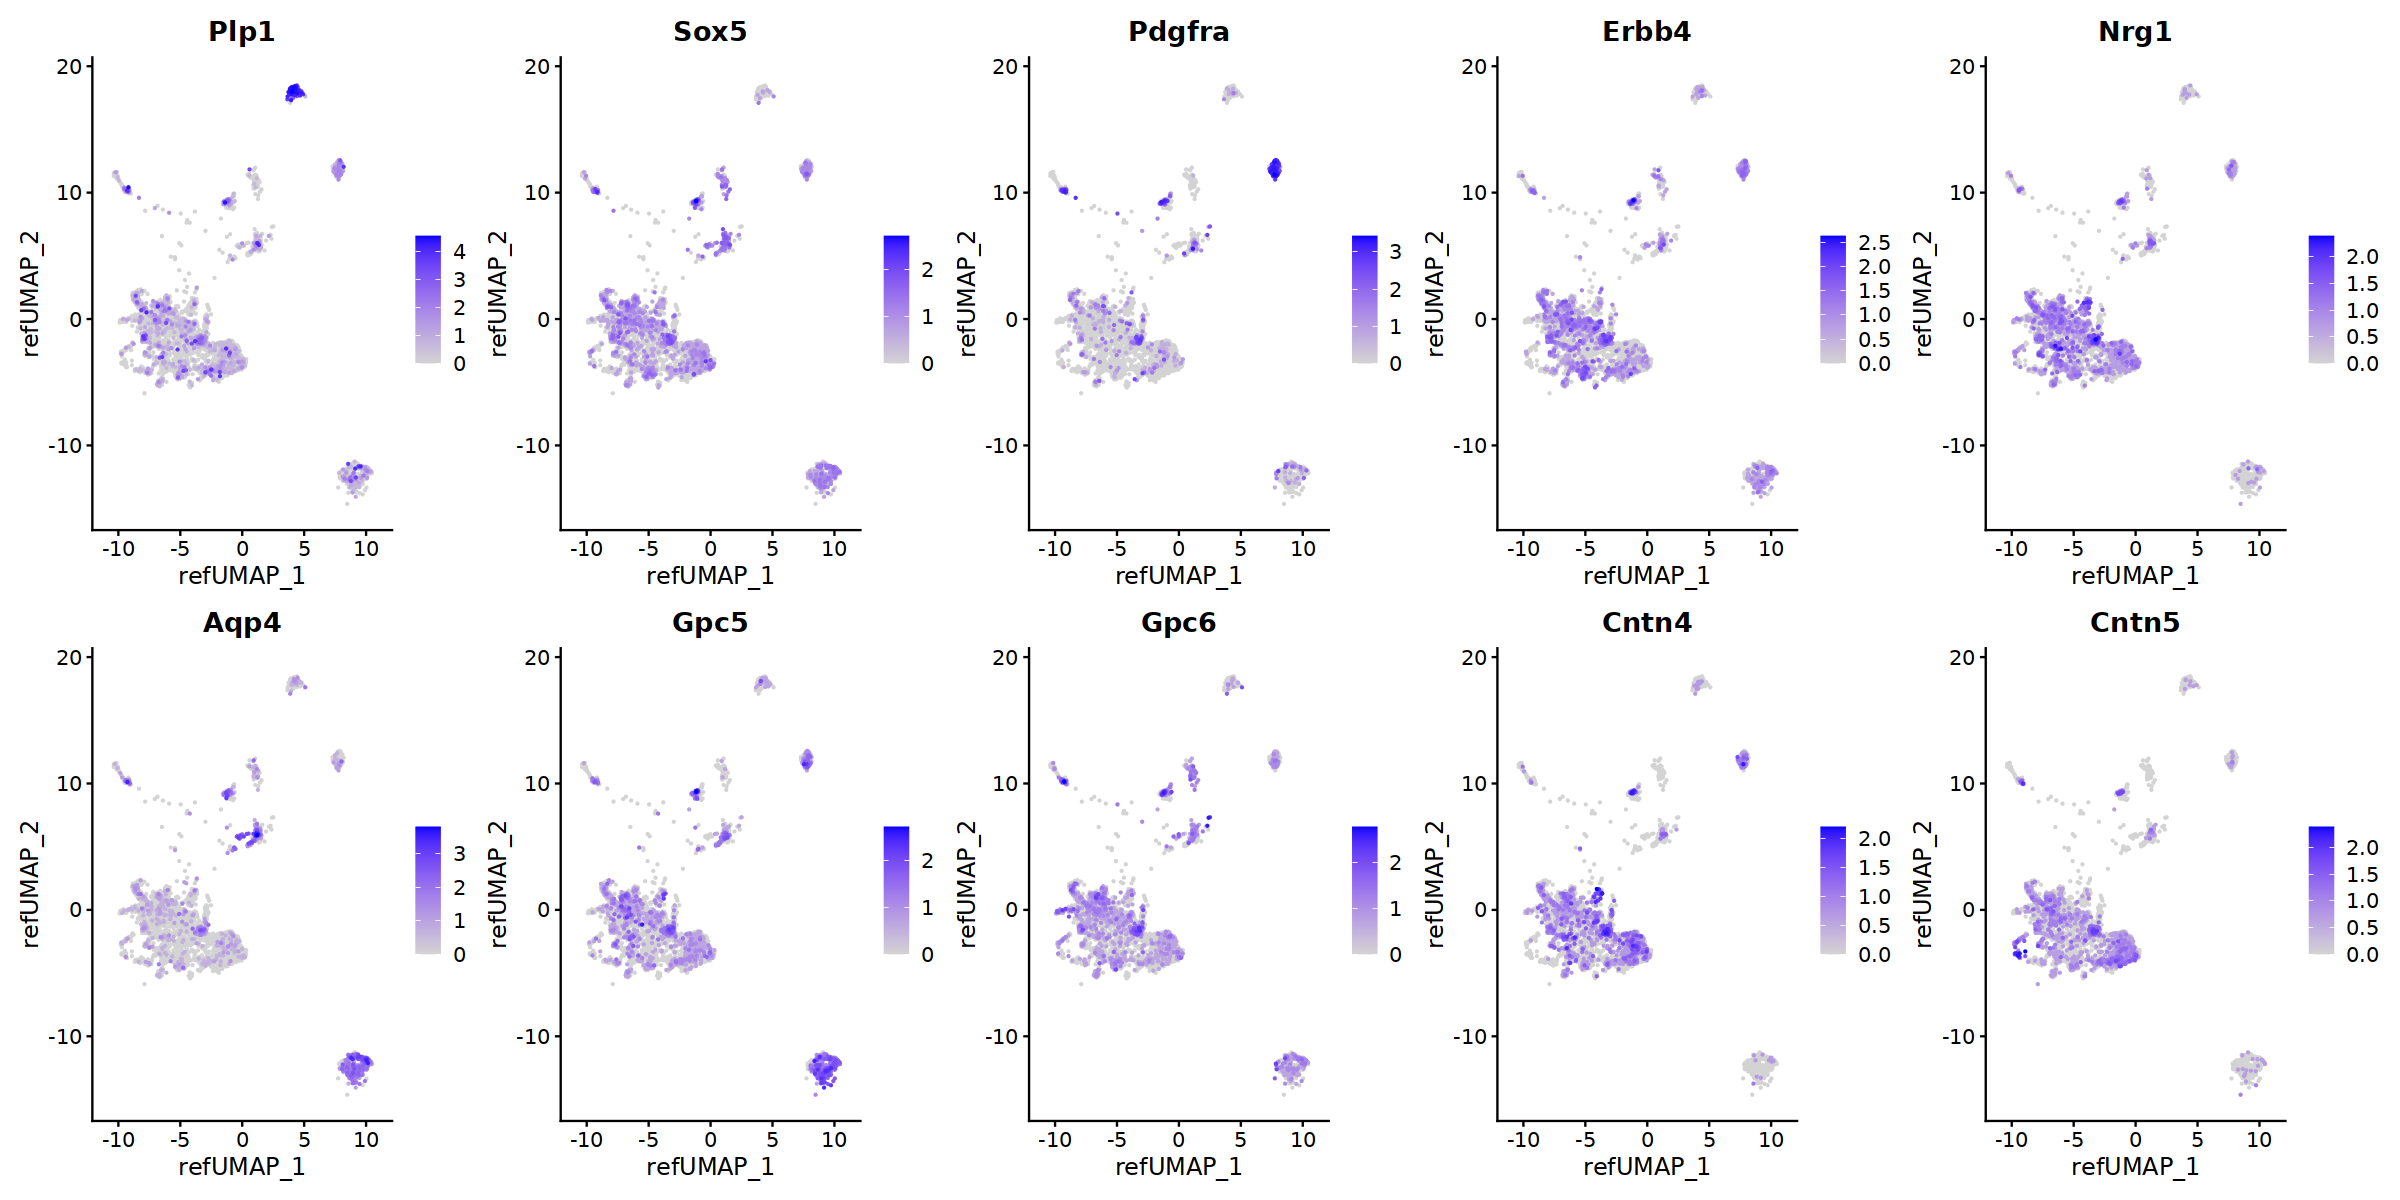

In [135]:
# FeaturePlot(xe_obj, top_neuron_markers, reduction = "umap", ncol = 5, order=TRUE)
options(repr.plot.width=20, repr.plot.height=10)

FeaturePlot(xe_obj,
            c("Plp1", "Sox5", "Pdgfra", "Erbb4", "Nrg1", "Aqp4", "Gpc5", "Gpc6", "Cntn4", "Cntn5"),
            reduction = "ref.umap",
            ncol=5, 
            order=TRUE)

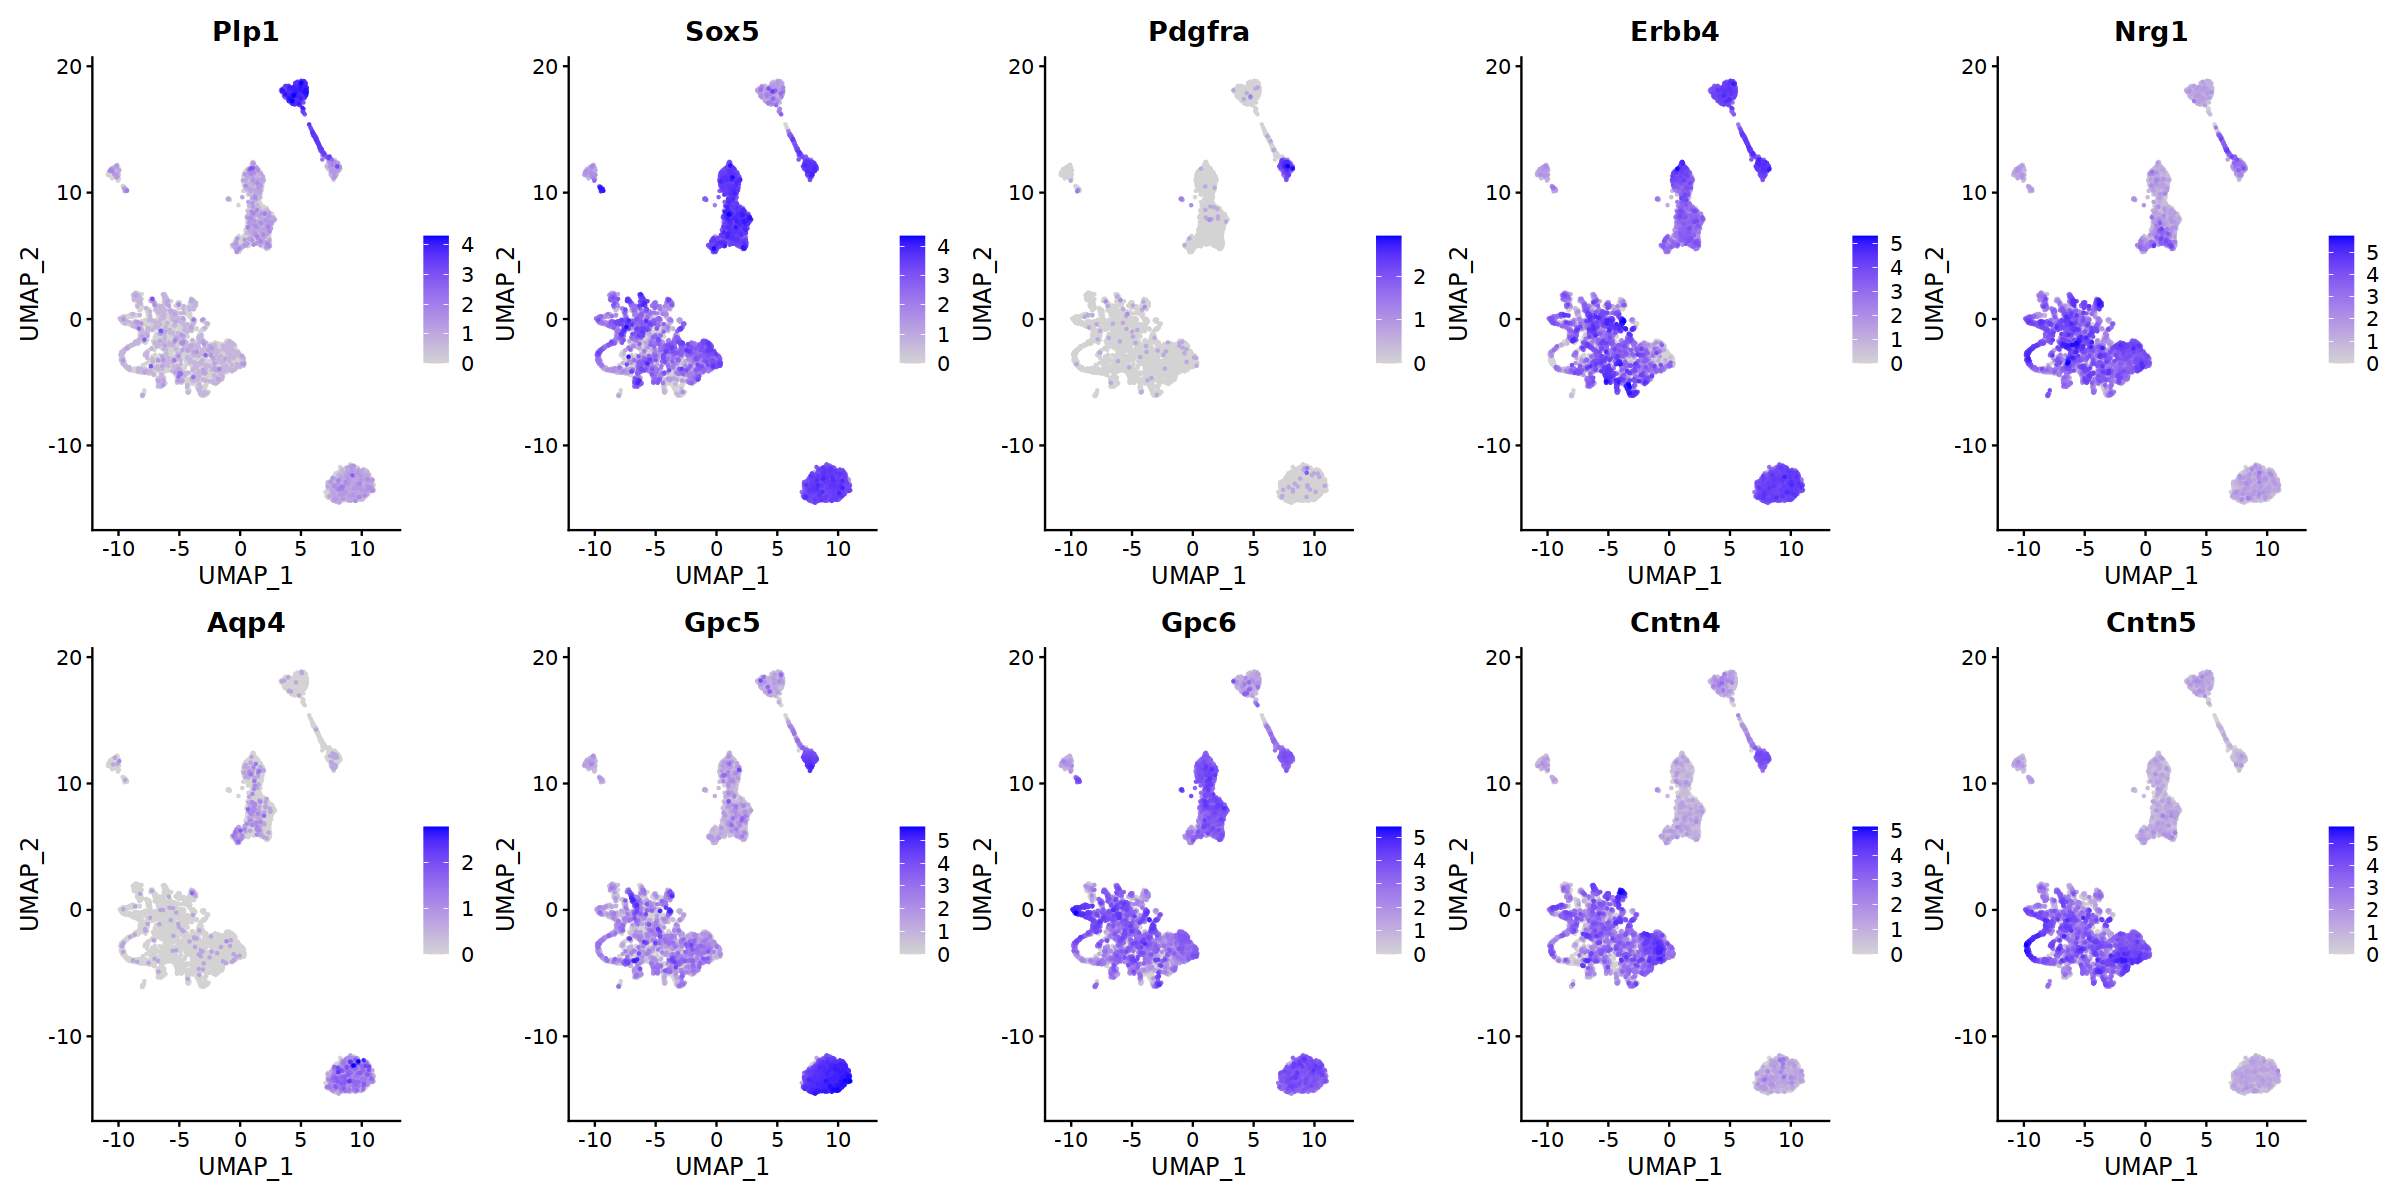

In [137]:
# FeaturePlot(xe_obj, top_neuron_markers, reduction = "umap", ncol = 5, order=TRUE)
options(repr.plot.width=20, repr.plot.height=10)

FeaturePlot(ref_obj,
            c("Plp1", "Sox5", "Pdgfra", "Erbb4", "Nrg1", "Aqp4", "Gpc5", "Gpc6", "Cntn4", "Cntn5"),
            reduction = "umap",
            ncol=5, 
            order=TRUE)

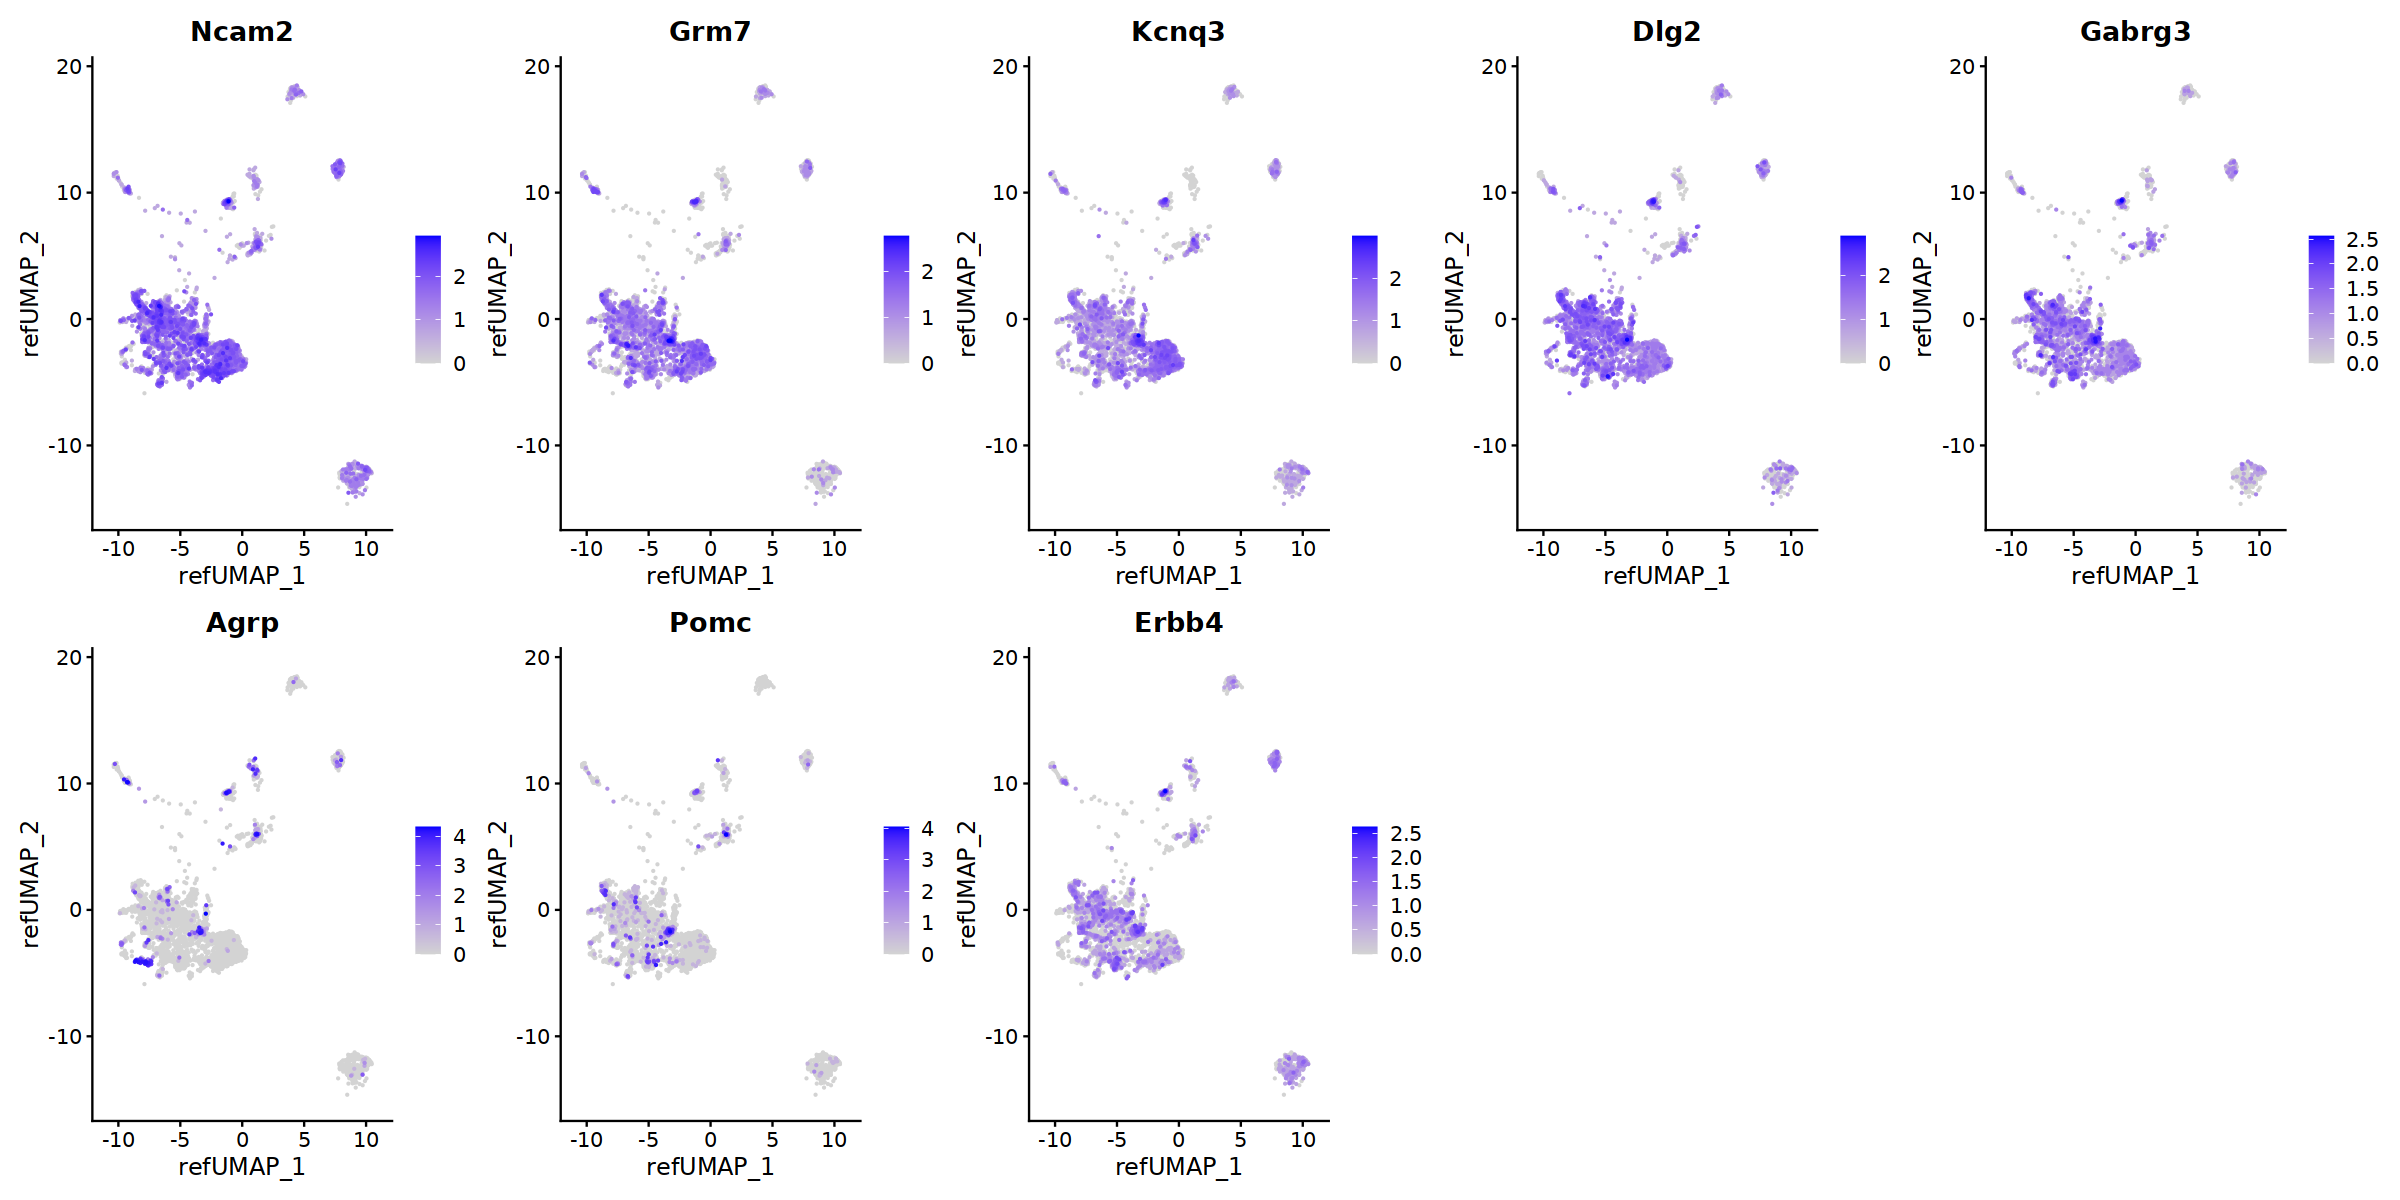

In [136]:
marker_genes <- c("Ncam2", "Grm7", "Kcnq3", "Dlg2", "Gabrg3", "Agrp", "Pomc", "Erbb4")


options(repr.plot.width=20, repr.plot.height=10)

FeaturePlot(xe_obj,
            marker_genes,
            reduction = "ref.umap",
            ncol=5, 
            order=TRUE)

In [140]:
xe_obj = FindNeighbors(xe_obj, assay = 'Xenium', slot='counts')
xe_obj = FindClusters(xe_obj)

Warning message:
“The following arguments are not used: slot”
Warning message:
“The following arguments are not used: slot”
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10717
Number of edges: 330177

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8318
Number of communities: 18
Elapsed time: 1 seconds


In [141]:
xe_obj %>% `[[` %>% colnames

[1] "orig.ident"               "nCount_Xenium"           
 [3] "nFeature_Xenium"          "nCount_BlankCodeword"    
 [5] "nFeature_BlankCodeword"   "nCount_ControlCodeword"  
 [7] "nFeature_ControlCodeword" "nCount_ControlProbe"     
 [9] "nFeature_ControlProbe"    "nCount_SCT"              
[11] "nFeature_SCT"             "SCT_snn_res.0.3"         
[13] "seurat_clusters"          "predicted.labels.score"  
[15] "predicted.labels"         "SCT_snn_res.0.8"

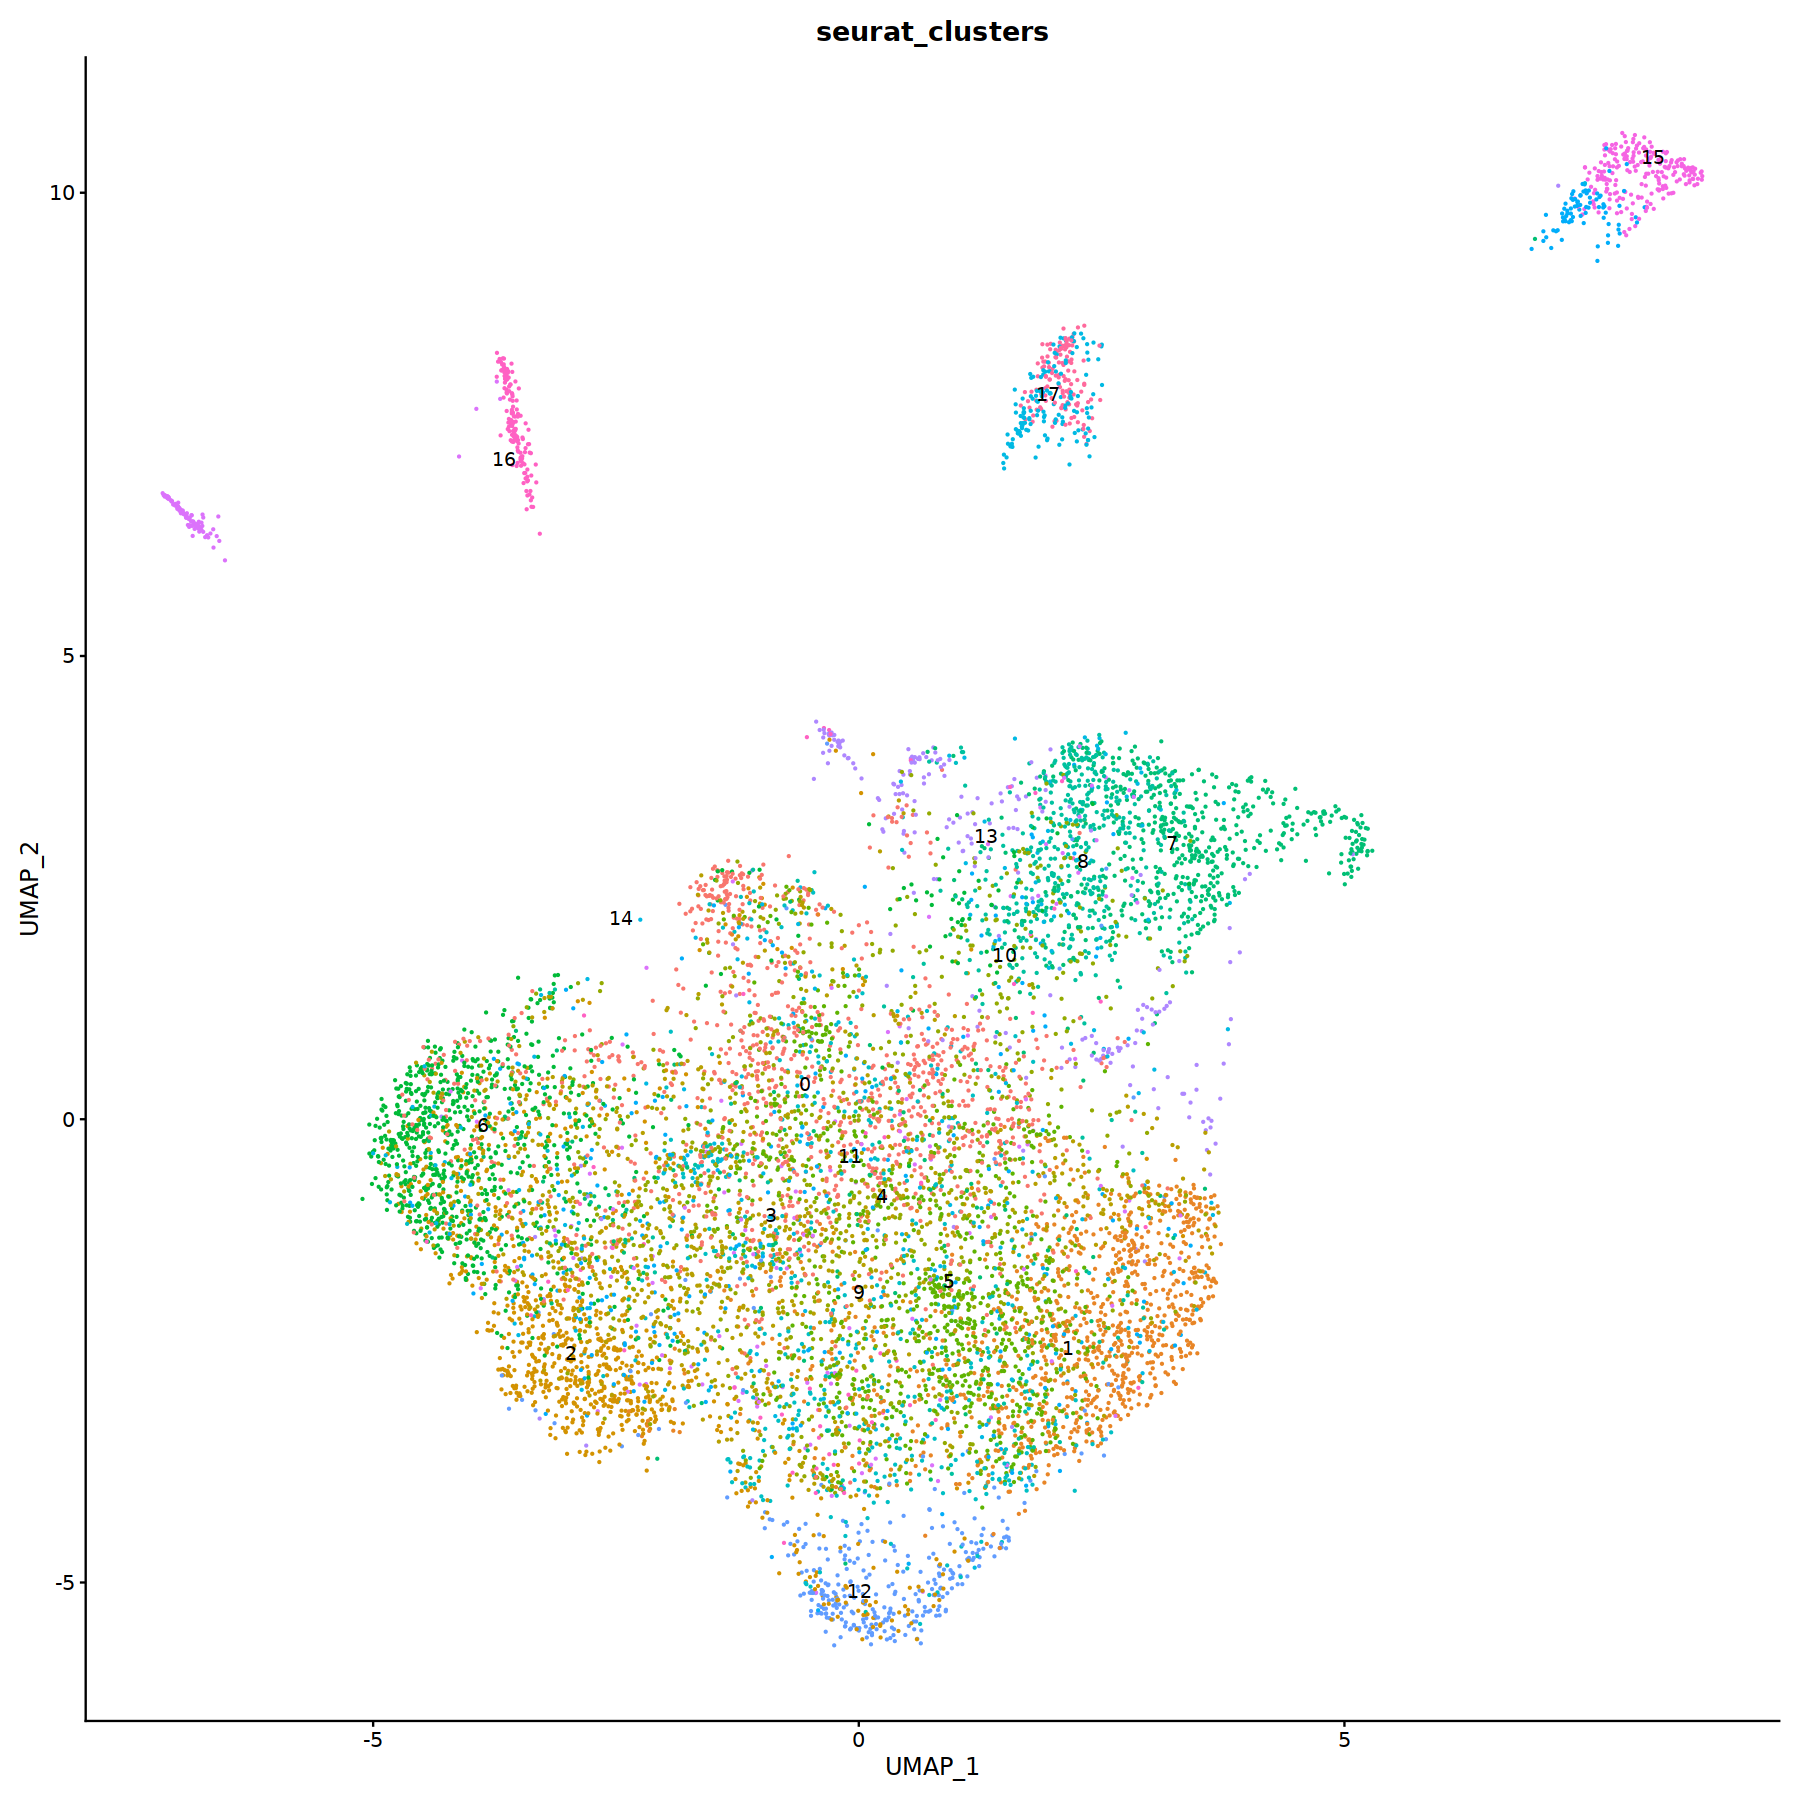

In [142]:
options(repr.plot.width=15, repr.plot.height=15)
DimPlot(xe_obj, reduction = "umap", group.by = "seurat_clusters", label = TRUE, repel = TRUE)+
  theme(legend.position = "none")



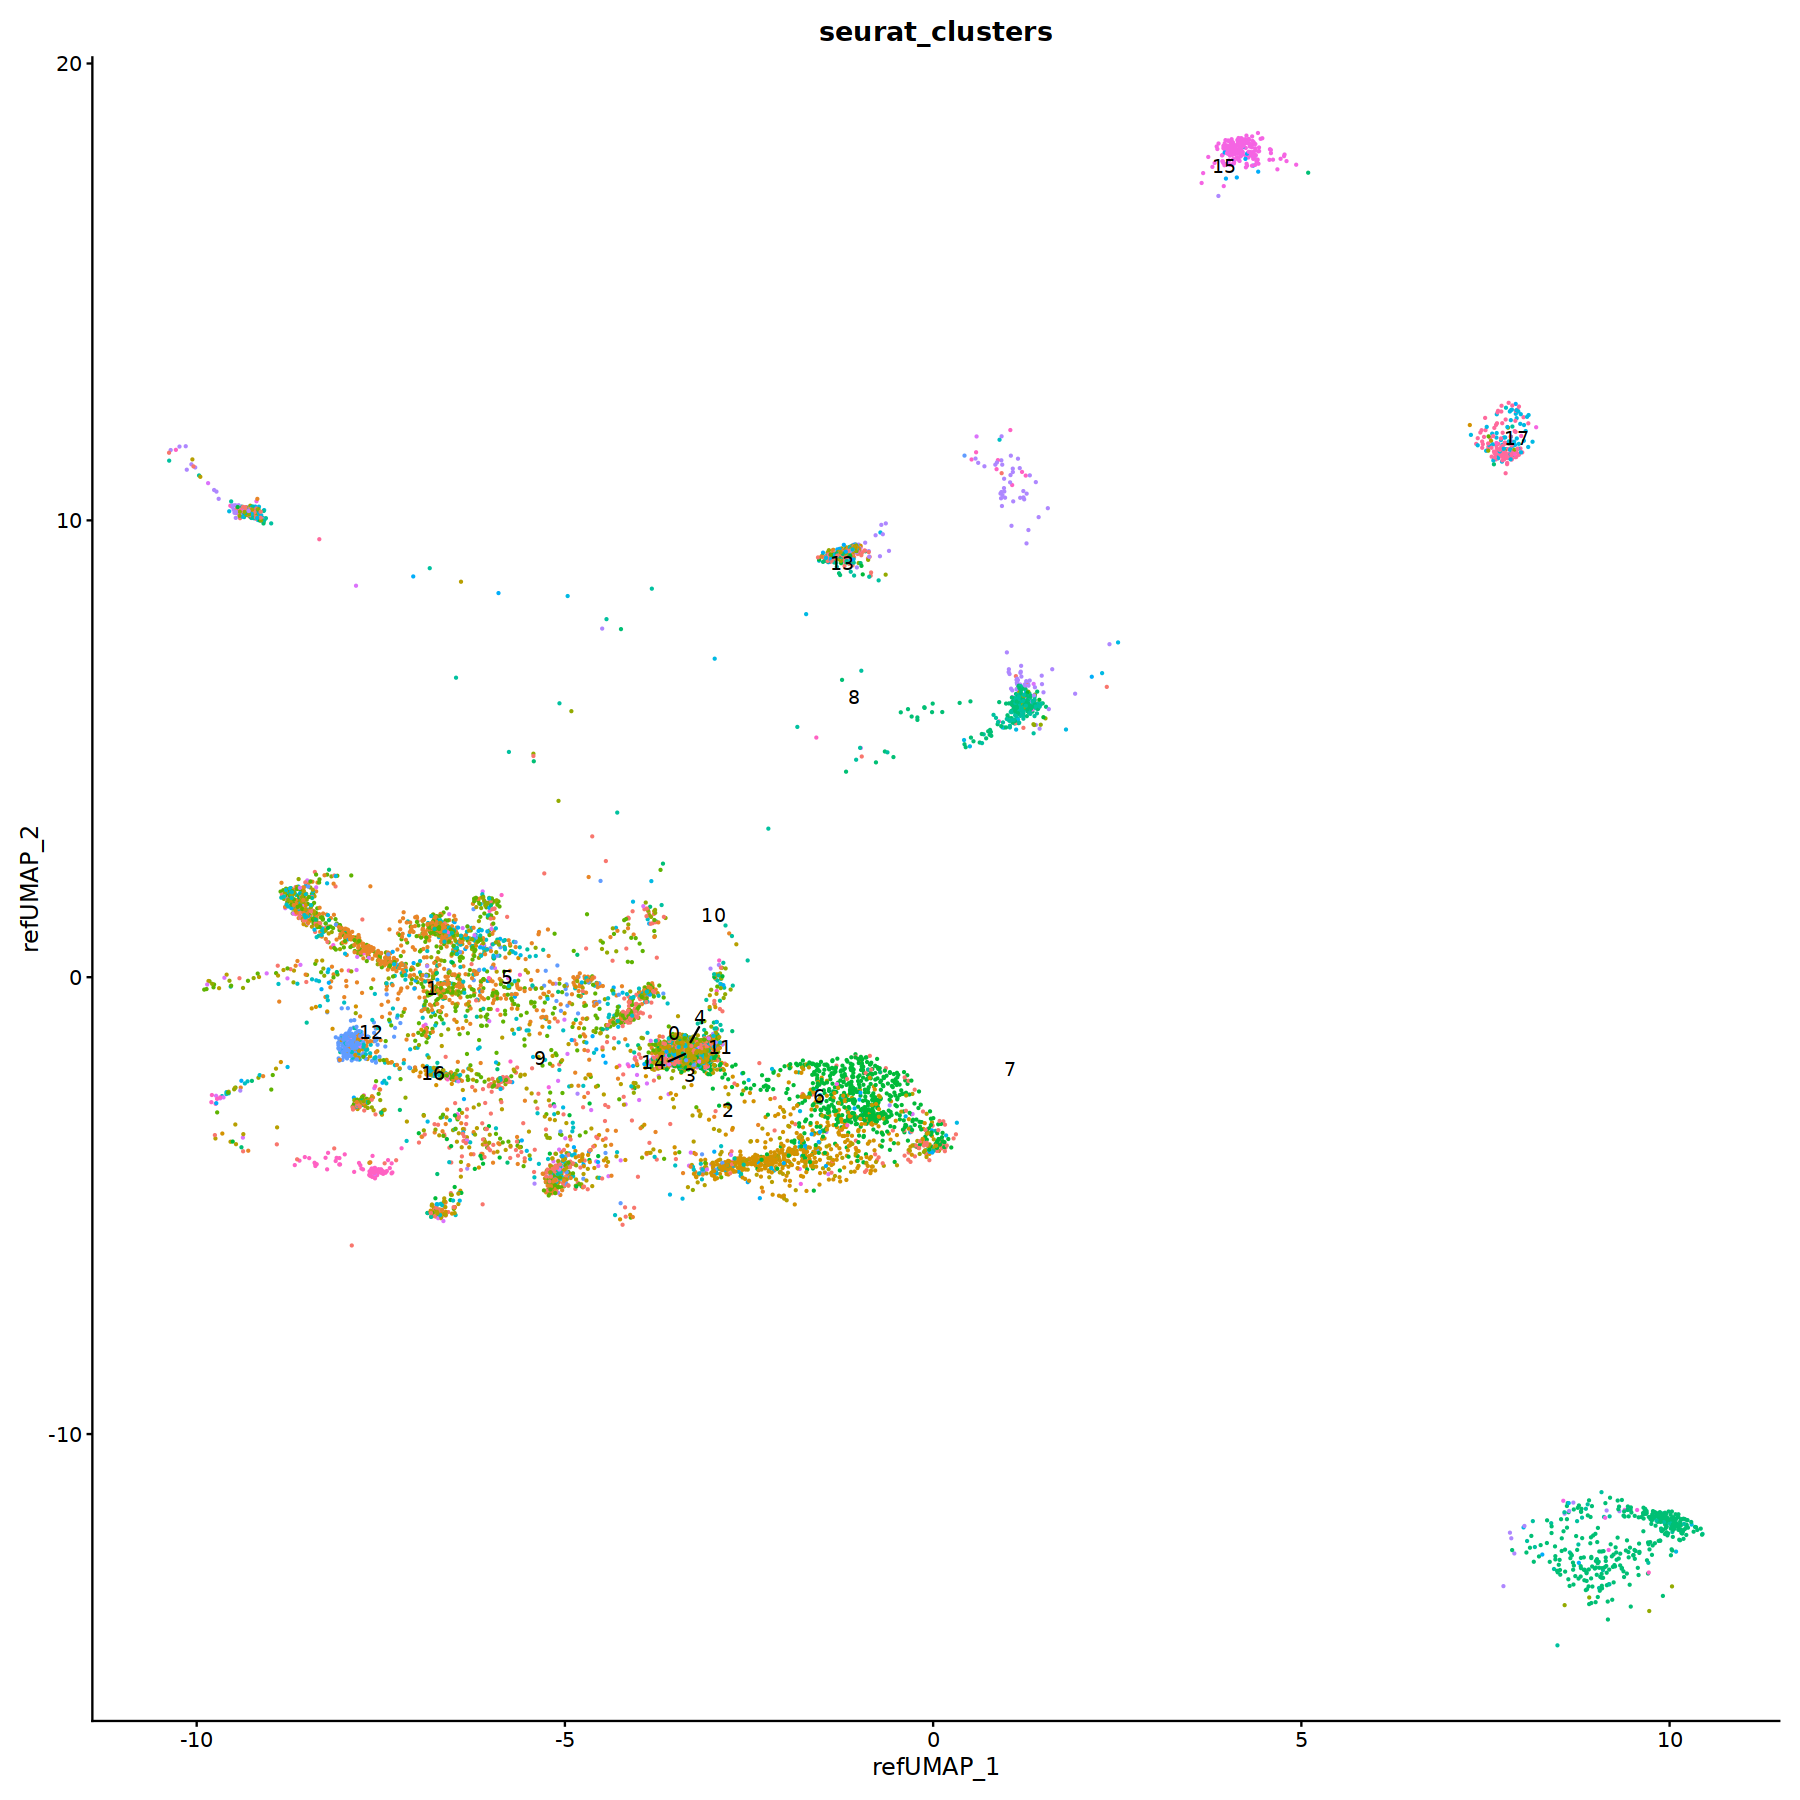

In [143]:
options(repr.plot.width=15, repr.plot.height=15)
DimPlot(xe_obj, reduction = "ref.umap", group.by = "seurat_clusters", label = TRUE, repel = TRUE)+
  theme(legend.position = "none")

